#  Código HBQP


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime
import pytz
%matplotlib inline
import matplotlib.colors as mcolors

In [3]:
names = list(mcolors.TABLEAU_COLORS)
colores = mcolors.TABLEAU_COLORS
colores[names[0]]

'#1f77b4'

In [4]:
#df1 = pd.read_excel('/content/drive/MyDrive/Proyecto de Título -Localización y gestión de equipamiento médico/Proyecto/Codigo-HBQP/Conexión nodos-HBQP-piso-1.xlsx')
#df2 = pd.read_excel('/content/drive/MyDrive/Proyecto de Título -Localización y gestión de equipamiento médico/Proyecto/Codigo-HBQP/Conexión enlaces-HBQP-piso-1.xlsx')

In [5]:
df1_m1 = pd.read_excel('/content/drive/MyDrive/Proyecto de Título -Localización y gestión de equipamiento médico/Proyecto/Codigo-HBQP/Conexión nodos-HBQP.xlsx', sheet_name='piso -1')
df2_m1 = pd.read_excel('/content/drive/MyDrive/Proyecto de Título -Localización y gestión de equipamiento médico/Proyecto/Codigo-HBQP/Conexión enlaces-HBQP.xlsx', sheet_name='piso -1')
df1_1 = pd.read_excel('/content/drive/MyDrive/Proyecto de Título -Localización y gestión de equipamiento médico/Proyecto/Codigo-HBQP/Conexión nodos-HBQP.xlsx', sheet_name='piso 1')
df2_1 = pd.read_excel('/content/drive/MyDrive/Proyecto de Título -Localización y gestión de equipamiento médico/Proyecto/Codigo-HBQP/Conexión enlaces-HBQP.xlsx', sheet_name='piso 1')
df1_2 = pd.read_excel('/content/drive/MyDrive/Proyecto de Título -Localización y gestión de equipamiento médico/Proyecto/Codigo-HBQP/Conexión nodos-HBQP.xlsx', sheet_name='piso 2')
df2_2 = pd.read_excel('/content/drive/MyDrive/Proyecto de Título -Localización y gestión de equipamiento médico/Proyecto/Codigo-HBQP/Conexión enlaces-HBQP.xlsx', sheet_name='piso 2')


In [6]:
df_inventario = pd.read_excel('/content/drive/MyDrive/Proyecto de Título -Localización y gestión de equipamiento médico/Proyecto/Codigo-HBQP/01. Inventario HBQP_20.10.22.xlsx')

# Trabajo de Datos  


> En esta sección trabajamos los datos del inventario de equipos médicos del HBQP, extrayendo valores de interés, conversiones y orden. Incluyendo asignación de número de inventario y cálculo de la frecuencia de mantenciones.



In [7]:
#Sacamos los valores de interés
df_INV = df_inventario[['PMA de Almacenamiento','Equipo','Marca','Modelo','N° de Serie','Fecha de Inicio de Periodo de Garantía','Fecha de Término de Periodo de Garantía','Frecuencia de Mantenimiento','Precio Unitario I.V.A. incluido']].copy()
df_INV.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48306 entries, 0 to 48305
Data columns (total 9 columns):
 #   Column                                   Non-Null Count  Dtype 
---  ------                                   --------------  ----- 
 0   PMA de Almacenamiento                    48306 non-null  object
 1   Equipo                                   48306 non-null  object
 2   Marca                                    48305 non-null  object
 3   Modelo                                   48280 non-null  object
 4   N° de Serie                              48110 non-null  object
 5   Fecha de Inicio de Periodo de Garantía   48306 non-null  object
 6   Fecha de Término de Periodo de Garantía  48306 non-null  object
 7   Frecuencia de Mantenimiento              48306 non-null  object
 8   Precio Unitario I.V.A. incluido          48306 non-null  object
dtypes: object(9)
memory usage: 3.3+ MB


In [8]:
df_INV['Fecha de Término de Periodo de Garantía'] = df_INV['Fecha de Término de Periodo de Garantía'].replace(['PENDIENTE',''])
df_INV['Fecha de Término de Periodo de Garantía'] = df_INV['Fecha de Término de Periodo de Garantía'].replace(['#VALUE!',''])
df_INV['Fecha de Inicio de Periodo de Garantía'] = df_INV['Fecha de Inicio de Periodo de Garantía'].replace(['PENDIENTE',''])

In [9]:
# Conversión a minúsculas y fechas
df_INV['Equipo'] = df_INV['Equipo'].str.lower()
df_INV['Marca'] = df_INV['Marca'].str.lower()
df_INV['Modelo'] = df_INV['Modelo'].str.lower()
df_INV['N° de Serie'] = df_INV['N° de Serie'].str.lower()
df_INV['Frecuencia de Mantenimiento'] = df_INV['Frecuencia de Mantenimiento'].str.lower()
df_INV['Precio Unitario I.V.A. incluido'] = df_INV['Precio Unitario I.V.A. incluido'].str.lower()
df_INV['Fecha de Inicio de Periodo de Garantía'] = pd.to_datetime(df_INV['Fecha de Inicio de Periodo de Garantía'])
df_INV['Fecha de Término de Periodo de Garantía'] = pd.to_datetime(df_INV['Fecha de Término de Periodo de Garantía'])
#df_INV.head(5)

In [10]:
# se ordenan los datos por equipo
df_INV = df_INV.sort_values(by=['Equipo'])
df_INV.reset_index(inplace=True, drop=True)
#df_INV

In [11]:
# asigno valores del 1 al largo de la cantidad de equipos (sin repetirse)
name_equipo = df_INV['Equipo'].unique()
initial_values = np.linspace(1,name_equipo.shape[0],name_equipo.shape[0]).astype(int)
final_values = np.linspace(1,df_INV.shape[0],df_INV.shape[0]).astype(int)

df_new = pd.DataFrame({'Equipo':name_equipo, 'inital_values':initial_values})
df_INV['final_values'] = final_values;

In [12]:
df_new.head()

,Equipo,inital_values
0,baño de flotación,1
1,abatidor de temperatura (hornos combi),2
2,abrelatas industrial,3
3,agitador con balanza para bolsa de sangre,4
4,agitador magnético,5


In [13]:
df_INV = df_INV.merge(df_new)

In [14]:
#Se inventa el núnero de inventario
df_INV['final_values'] = df_INV['final_values'].astype(str)
df_INV['inital_values'] = df_INV['inital_values'].astype(str)
df_INV['Número Inventario'] = df_INV['inital_values'] + '-' + df_INV['final_values']
df_INV.head(5)

,PMA de Almacenamiento,Equipo,Marca,Modelo,N° de Serie,Fecha de Inicio de Periodo de Garantía,Fecha de Término de Periodo de Garantía,Frecuencia de Mantenimiento,Precio Unitario I.V.A. incluido,final_values,inital_values,Número Inventario
0,B-2-6,baño de flotación,thermo microm,hm 325,NaN,2022-07-01,2024-07-01,anual: cada 12 meses,NaN,1,1,1-1
1,B-2-6,baño de flotación,thermo microm,hm 325,NaN,2022-07-02,2024-07-02,anual: cada 12 meses,NaN,2,1,1-2
2,G-S1-33,abatidor de temperatura (hornos combi),desmon,gbf20gn11,i5p0p005785,2021-11-17,2024-11-17,trimestral: cada 3 meses,NaN,3,2,2-3
3,G-S1-22,abrelatas industrial,lacor,al-50,s/n,2021-04-16,2023-05-16,no aplica,NaN,4,3,3-4
4,G-S1-22,abrelatas industrial,lacor,al-50,s/n,2021-04-16,2023-05-16,no aplica,NaN,5,3,3-5


In [15]:
#La frecuencia de las mantenciones que son anuales, trimestrales , se calculan con la fecha de inicio de la garantía.
from datetime import datetime
from dateutil.relativedelta import relativedelta

date_mantencion = []
freq_mantencion = []
for idx in range(df_INV.shape[0]):
  split_name = df_INV['Frecuencia de Mantenimiento'][idx].split()
  name_id = split_name[0].split(':')

  # fecha actual
  actual_date = datetime.now()

  if name_id[0]=='anual':
    for n in range(4):
      result = df_INV['Fecha de Inicio de Periodo de Garantía'][idx] + relativedelta(months=+12*(n+1))
      if result>actual_date:
        break
    date_mantencion.append(result)
    freq_mantencion.append('anual')

  elif name_id[0]=='trimestral':
    for n in range(24):
      result = df_INV['Fecha de Inicio de Periodo de Garantía'][idx] + relativedelta(months=+3*(n+1))
      if result>actual_date:
        break
    date_mantencion.append(result)
    freq_mantencion.append('trimestral')

  elif name_id[0]=='semestral':
    for n in range(24):
      result = df_INV['Fecha de Inicio de Periodo de Garantía'][idx] + relativedelta(months=+6*(n+1))
      if result>actual_date:
        break
    date_mantencion.append(result)
    freq_mantencion.append('semestral')

  else:
    date_mantencion.append('')
    freq_mantencion.append('no aplica')

In [16]:
df_INV['FreqMantencion'] = freq_mantencion
df_INV['Mantencion'] = date_mantencion

<ipython-input-16-4dc0cc26cc81>:2: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype={value.dtype})
  df_INV['Mantencion'] = date_mantencion


In [17]:
# Eliminamos todos los nodos los cuales no contienen coordenada de texto
df_nodos = pd.concat([df1_m1, df1_1, df1_2])
df_enlaces = pd.concat([df2_m1, df2_1, df2_2])

df_nodos.reset_index(inplace=True, drop=True)
df_enlaces.reset_index(inplace=True, drop=True)

In [18]:
df_nodos

,Nodo,Piso0,Piso1,Piso2,Sala,Pasillo,Otro,Distancia x,Distancia y,Distancia xn,Distancia yn,Cor_tex x,Cor_tex y,rotacion
0,C-S1-1,1.0,0.0,0.0,1.0,0.0,0.0,135.0,15.0,-0.410480,-0.032258,135.0,17.0,90.0
1,C-S1-3,1.0,0.0,0.0,1.0,0.0,0.0,135.0,10.0,-0.410480,-0.354839,135.0,12.0,90.0
2,C-S1-4,1.0,0.0,0.0,1.0,0.0,0.0,197.0,15.0,-0.139738,-0.032258,197.0,17.0,90.0
3,C-S1-5,1.0,0.0,0.0,1.0,0.0,0.0,197.0,10.0,-0.139738,-0.354839,190.0,12.0,90.0
4,EQ-1,1.0,0.0,0.0,0.0,1.0,0.0,215.0,10.0,-0.061135,-0.354839,NaN,NaN,90.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
736,ASC P 5,0.0,1.0,1.0,0.0,0.0,1.0,444.0,-150.0,0.465347,-2.530612,442.0,-135.0,90.0
737,ASC P 6,1.0,1.0,1.0,0.0,0.0,1.0,49.0,14.0,-0.838284,-0.857143,38.0,9.0,0.0
738,ASC P 7,1.0,1.0,1.0,0.0,0.0,1.0,310.0,31.0,0.023102,-0.683673,315.0,31.0,0.0
739,ASC P 8,0.0,1.0,1.0,0.0,0.0,1.0,443.0,26.0,0.462046,-0.734694,411.0,24.0,0.0


In [19]:
df_nodos = df_nodos.drop_duplicates(subset=['Nodo'])
df_nodos.reset_index(inplace=True, drop=True)

In [20]:
df_nodos.head(5)

,Nodo,Piso0,Piso1,Piso2,Sala,Pasillo,Otro,Distancia x,Distancia y,Distancia xn,Distancia yn,Cor_tex x,Cor_tex y,rotacion
0,C-S1-1,1.0,0.0,0.0,1.0,0.0,0.0,135.0,15.0,-0.410480,-0.032258,135.0,17.0,90.0
1,C-S1-3,1.0,0.0,0.0,1.0,0.0,0.0,135.0,10.0,-0.410480,-0.354839,135.0,12.0,90.0
2,C-S1-4,1.0,0.0,0.0,1.0,0.0,0.0,197.0,15.0,-0.139738,-0.032258,197.0,17.0,90.0
3,C-S1-5,1.0,0.0,0.0,1.0,0.0,0.0,197.0,10.0,-0.139738,-0.354839,190.0,12.0,90.0
4,EQ-1,1.0,0.0,0.0,0.0,1.0,0.0,215.0,10.0,-0.061135,-0.354839,NaN,NaN,90.0


# Elaboración Grafo Principal de pisos subterráneo, uno y dos del HBPQ


> Se presentan al asignación de nodo y enlaces al grafo, como también la creación del grafo principal de los pisos ya mencionados 



In [21]:
# inicializamos el grafo
G = nx.Graph()

## Nodos

In [22]:
# asignamos nodos al grafo
for idx in range(df_nodos.shape[0]):
  G.add_node(df_nodos['Nodo'][idx], Planta=[df_nodos['Piso0'][idx],df_nodos['Piso1'][idx],df_nodos['Piso2'][idx]])
  if df_nodos['Sala'][idx]==1:
    mask  = df_INV['PMA de Almacenamiento']==df_nodos['Nodo'][idx]
    df_temp = df_INV[mask].copy()
    df_temp = df_temp.reset_index(drop = True)
    for n in range(df_temp.shape[0]):
      G.nodes[df_nodos['Nodo'][idx]]['Equipo-'+str(n+1)] = df_temp['Equipo'][n]
      G.nodes[df_nodos['Nodo'][idx]]['Marca-'+str(n+1)] = df_temp['Marca'][n]
      G.nodes[df_nodos['Nodo'][idx]]['Modelo-'+str(n+1)] = df_temp['Modelo'][n]
      G.nodes[df_nodos['Nodo'][idx]]['NSerie-'+str(n+1)] = df_temp['N° de Serie'][n]
      G.nodes[df_nodos['Nodo'][idx]]['NInventario-'+str(n+1)] = df_temp['Número Inventario'][n]
      G.nodes[df_nodos['Nodo'][idx]]['Mantencion-'+str(n+1)] = df_temp['Mantencion'][n]
      G.nodes[df_nodos['Nodo'][idx]]['FreqMantencion-'+str(n+1)] = df_temp['FreqMantencion'][n]
      G.nodes[df_nodos['Nodo'][idx]]['LimiteGarantia-'+str(n+1)] = df_temp['Fecha de Término de Periodo de Garantía'][n]


In [23]:
G.nodes

NodeView(('C-S1-1', 'C-S1-3', 'C-S1-4', 'C-S1-5', 'EQ-1', 'P-1', 'P-2', 'P-3', 'P-4', 'P-5', 'P-6', 'P-7', 'P-8', 'P-9', 'P-10', 'P-11', 'P-12', 'P-13', 'P-14', 'P-15', 'P-16', 'P-17', 'P-18', 'P-19', 'P-20', 'P-21', 'P-22', 'P-23', 'P-24', 'P-25', 'ESC 1', 'ESC 2', 'ESC 3', 'ASC C-EQ 1', 'ASC C-EQ 2', 'ASC C-EQ 3', 'ASC C-EQ 5', 'ASC C-EQ 6', 'ASC P 1', 'ASC P 2', 'ASC P 3', 'ASC P 6', 'ASC P 7', 'ASC P 9', 'B-1-28', 'B-1-11', 'B-1-26', 'B-1-29', 'B-1-15', 'B-1-16', 'B-1-24', 'B-1-23', 'B-1-14', 'B-1-7', 'B-1-9', 'B-1-8', 'B-1-10', 'B-1-12', 'B-1-40', 'B-1-45', 'B-1-47', 'B-1-5', 'B-1-19', 'B-1-13', 'B-1-35', 'B-1-2', 'B-1-1', 'C-1-12', 'C-1-18', 'C-1-9', 'C-1-8', 'C-1-10', 'C-1-11', 'C-1-7', 'D-1-17', 'D-1-22', 'D-1-29', 'D-1-23', 'D-1-3', 'D-1-4', 'D-1-5', 'D-1-6', 'E-1-41', 'E-1-21', 'E-1-33', 'E-1-10', 'E-1-7', 'E-1-6', 'E-1-5', 'E-1-11', 'E-1-12', 'E-1-13', 'E-1-14', 'E-1-16', 'E-1-15', 'E-1-19', 'E-1-37', 'E-1-20', 'E-1-18', 'E-1-22', 'E-1-8', 'E-1-9', 'E-1-17', 'E-1-55', 'H-1-2

In [24]:
G.nodes['E-1-17']

{'Planta': [0.0, 1.0, 0.0],
 'Equipo-1': 'autorrefractómetro con queratometría ',
 'Marca-1': 's/m',
 'Modelo-1': 's/m',
 'NSerie-1': 's/n',
 'NInventario-1': '33-745',
 'Mantencion-1': Timestamp('2023-11-26 00:00:00'),
 'FreqMantencion-1': 'anual',
 'LimiteGarantia-1': Timestamp('2023-11-26 00:00:00'),
 'Equipo-2': 'autorrefractómetro con queratometría ',
 'Marca-2': 's/m',
 'Modelo-2': 's/m',
 'NSerie-2': 's/n',
 'NInventario-2': '33-746',
 'Mantencion-2': Timestamp('2023-11-26 00:00:00'),
 'FreqMantencion-2': 'anual',
 'LimiteGarantia-2': Timestamp('2023-11-26 00:00:00'),
 'Equipo-3': 'autorrefractómetro con queratometría ',
 'Marca-3': 'luxvision',
 'Modelo-3': 's/m',
 'NSerie-3': 's/n',
 'NInventario-3': '33-747',
 'Mantencion-3': Timestamp('2023-11-26 00:00:00'),
 'FreqMantencion-3': 'anual',
 'LimiteGarantia-3': Timestamp('2023-11-26 00:00:00'),
 'Equipo-4': 'autorrefractómetro con queratometría ',
 'Marca-4': 'ezer-us ophthalmic',
 'Modelo-4': 'erk-9100',
 'NSerie-4': '9rk00019

## Enlaces

In [25]:
# asignamos los enlaces al grafo
for idx in range(df_enlaces.shape[0]):
    for idx2 in range(df_nodos.shape[0]):
        if df_nodos['Nodo'][idx2] == df_enlaces['Nodo1'][idx]:
            var1 = np.array([df_nodos['Distancia x'][idx2],df_nodos['Distancia y'][idx2]])
    
        elif df_nodos['Nodo'][idx2] == df_enlaces['Nodo2'][idx]:
            var2 = np.array([df_nodos['Distancia x'][idx2],df_nodos['Distancia y'][idx2]])

    distancia = np.sqrt(np.sum((var1-var2)**2))      
    G.add_edge(df_enlaces['Nodo1'][idx], df_enlaces['Nodo2'][idx], Planta=[df_enlaces['Piso0'][idx],df_enlaces['Piso1'][idx],df_enlaces['Piso2'][idx]], distancia=distancia)

In [26]:
G.nodes

NodeView(('C-S1-1', 'C-S1-3', 'C-S1-4', 'C-S1-5', 'EQ-1', 'P-1', 'P-2', 'P-3', 'P-4', 'P-5', 'P-6', 'P-7', 'P-8', 'P-9', 'P-10', 'P-11', 'P-12', 'P-13', 'P-14', 'P-15', 'P-16', 'P-17', 'P-18', 'P-19', 'P-20', 'P-21', 'P-22', 'P-23', 'P-24', 'P-25', 'ESC 1', 'ESC 2', 'ESC 3', 'ASC C-EQ 1', 'ASC C-EQ 2', 'ASC C-EQ 3', 'ASC C-EQ 5', 'ASC C-EQ 6', 'ASC P 1', 'ASC P 2', 'ASC P 3', 'ASC P 6', 'ASC P 7', 'ASC P 9', 'B-1-28', 'B-1-11', 'B-1-26', 'B-1-29', 'B-1-15', 'B-1-16', 'B-1-24', 'B-1-23', 'B-1-14', 'B-1-7', 'B-1-9', 'B-1-8', 'B-1-10', 'B-1-12', 'B-1-40', 'B-1-45', 'B-1-47', 'B-1-5', 'B-1-19', 'B-1-13', 'B-1-35', 'B-1-2', 'B-1-1', 'C-1-12', 'C-1-18', 'C-1-9', 'C-1-8', 'C-1-10', 'C-1-11', 'C-1-7', 'D-1-17', 'D-1-22', 'D-1-29', 'D-1-23', 'D-1-3', 'D-1-4', 'D-1-5', 'D-1-6', 'E-1-41', 'E-1-21', 'E-1-33', 'E-1-10', 'E-1-7', 'E-1-6', 'E-1-5', 'E-1-11', 'E-1-12', 'E-1-13', 'E-1-14', 'E-1-16', 'E-1-15', 'E-1-19', 'E-1-37', 'E-1-20', 'E-1-18', 'E-1-22', 'E-1-8', 'E-1-9', 'E-1-17', 'E-1-55', 'H-1-2

In [27]:
G.edges

EdgeView([('C-S1-1', 'C-S1-4'), ('C-S1-3', 'C-S1-5'), ('C-S1-4', 'C-S1-5'), ('C-S1-5', 'EQ-1'), ('EQ-1', 'P-8'), ('P-1', 'P-2'), ('P-2', 'ESC 1'), ('P-2', 'P-3'), ('P-3', 'P-4'), ('P-3', 'P-25'), ('P-4', 'P-5'), ('P-4', 'P-19'), ('P-5', 'P-6'), ('P-5', 'P-24'), ('P-6', 'P-7'), ('P-6', 'P-20'), ('P-7', 'ESC 2'), ('P-7', 'P-8'), ('P-8', 'P-9'), ('P-8', 'P-18'), ('P-9', 'P-10'), ('P-9', 'P-17'), ('P-10', 'P-11'), ('P-10', 'P-22'), ('P-11', 'P-12'), ('P-11', 'P-21'), ('P-12', 'ESC 3'), ('P-12', 'P-13'), ('P-13', 'P-14'), ('P-13', 'P-16'), ('P-14', 'P-15'), ('P-14', 'P-23'), ('P-15', 'ASC C-EQ 3'), ('P-16', 'ASC P 3'), ('P-17', 'ASC C-EQ 2'), ('P-18', 'ASC P 2'), ('P-19', 'ASC P 6'), ('P-20', 'ASC C-EQ 5'), ('P-21', 'ASC C-EQ 6'), ('P-22', 'ASC P 7'), ('P-23', 'ASC P 9'), ('P-24', 'ASC C-EQ 1'), ('P-25', 'ASC P 1'), ('ESC 1', 'p1-21'), ('ESC 1', 'UPCA-1'), ('ESC 2', 'UA-1'), ('ESC 2', 'p1-9'), ('ESC 2', 'PB-1'), ('ESC 3', 'UI-5'), ('ESC 3', 'p1-15'), ('ESC 3', 'UNEO-1'), ('ASC C-EQ 1', 'p1-

## Generación de la red


In [58]:
def posicion(df_nodos, piso):
  ################################################################################
  # vector que contiene los nombres y las posiciones para el piso seleccionado
  pos = []
  nombres = []
  sala = []
  pasillo = []
  otro = []
  for idx2 in range(df_nodos.shape[0]):
      if df_nodos['Piso' + piso][idx2]==1:
          tupla_coor = (df_nodos['Distancia x'][idx2],df_nodos['Distancia y'][idx2])
          nombres.append(df_nodos['Nodo'][idx2])
          sala.append(df_nodos['Sala'][idx2])
          pasillo.append(df_nodos['Pasillo'][idx2])
          otro.append(df_nodos['Otro'][idx2])
          pos.append([df_nodos['Nodo'][idx2],tupla_coor])
  pos = dict(pos)

  ################################################################################
  # generamos un data frame solo con los nodos para poder graficar
  df_nodes = pd.DataFrame({'Nodos':nombres, 'Sala': sala, 'Pasillo': pasillo, 'Otro': otro})
  return pos, df_nodes


In [59]:
def normalizacion_cantidad_equipos(H, df_nodes, factor_normalizacion):
  # vamos a normalizar los valores de la cantidad de equipos por sala para que los circulos no crescan tanto en el grafico. 
  cantidad_de_equipos = []
  for name in list(df_nodes.Nodos[df_nodes.Sala==1]):
      s = pd.Series(H.nodes[name].keys())
      out = s.str.findall('Equipo')
      cantidad_de_equipos.append(len([1 for n in out if n]))

  cantidad_de_equipos = np.array(cantidad_de_equipos)

  # normalizamos el valor para que quede entre 0 y factor_normalizacion
  c_equipos = (cantidad_de_equipos/np.max(cantidad_de_equipos))*factor_normalizacion

  return c_equipos, cantidad_de_equipos

In [60]:
# subterraneo
df_nodos_p0 = df1_m1
df_nodos_p0 = df_nodos_p0.dropna()
df_nodos_p0 = df_nodos_p0.reset_index(drop=True)

# piso 1
df_nodos_p1 = df1_1
df_nodos_p1 = df_nodos_p1.dropna()
df_nodos_p1 = df_nodos_p1.reset_index(drop=True)

# piso 2
df_nodos_p2 = df1_2
df_nodos_p2 = df_nodos_p2.dropna()
df_nodos_p2 = df_nodos_p2.reset_index(drop=True)

In [61]:
#df_nodos_p1[df_nodos_p1.Nodo=='ESC 1']

## Grafo Principal - pisos subterráneo, uno y dos.


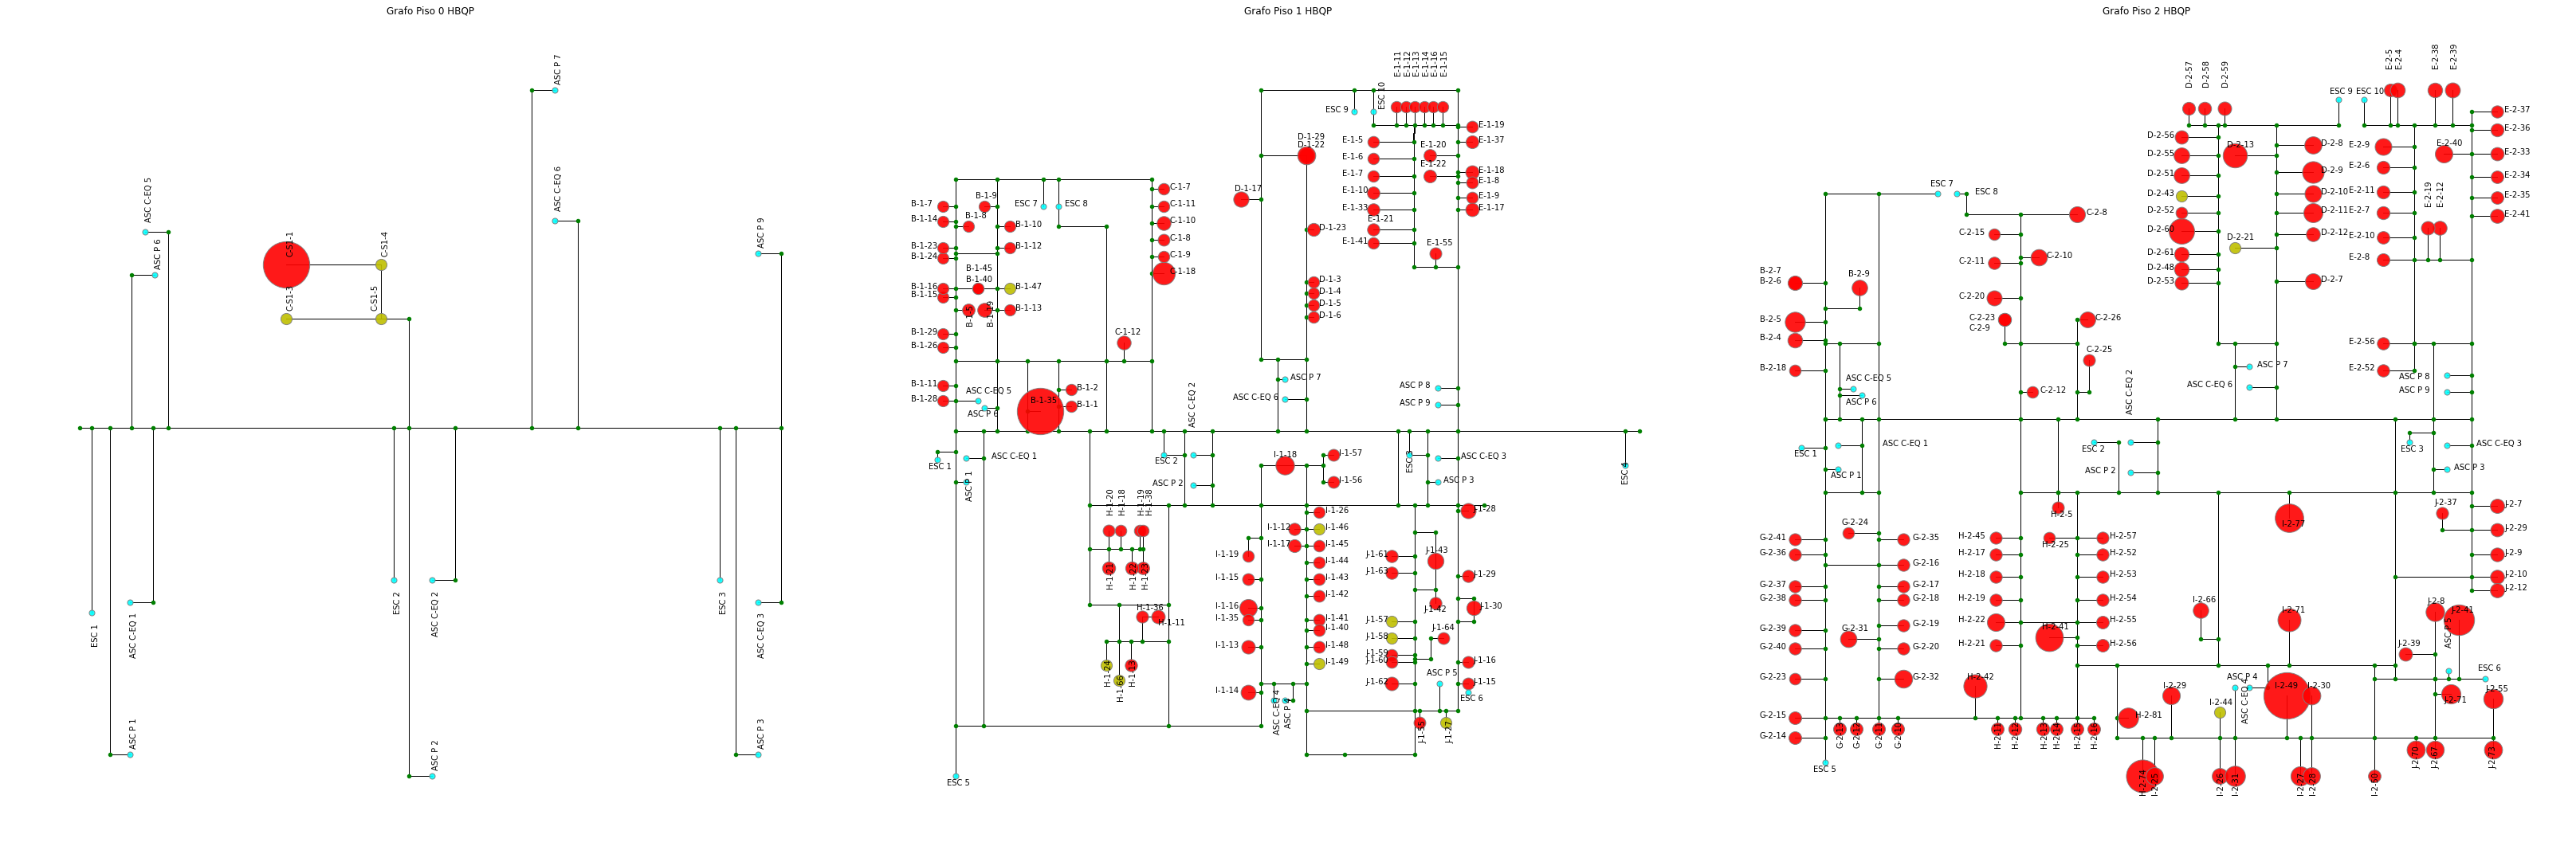

In [34]:
################################################################################
# cual es el piso que deseamos mostrar
pos1, df_nodes1 = posicion(df_nodos, '0')
pos2, df_nodes2 = posicion(df_nodos, '1')
pos3, df_nodes3 = posicion(df_nodos, '2')

################################################################################
# subgrafo solo para los nodos pertenecientes a cada piso selecionado
H1 = G.subgraph(list(df_nodes1.Nodos))
H2 = G.subgraph(list(df_nodes2.Nodos))
H3 = G.subgraph(list(df_nodes3.Nodos))

################################################################################
# vamos a normalizar los valores de la cantidad de equipos por sala para que ###
# los circulos no crescan tanto en el grafico. #################################
################################################################################
c_equipos_norm1, c_equipos1 = normalizacion_cantidad_equipos(H1, df_nodes1, 16)
c_equipos_norm2, c_equipos2 = normalizacion_cantidad_equipos(H2, df_nodes2, 16)
c_equipos_norm3, c_equipos3 = normalizacion_cantidad_equipos(H3, df_nodes3, 16)

################################################################################
# opciones que se repiten en todos los nodos
options = {"edgecolors": "tab:gray", "alpha": 0.9}

################################################################################
# mostramos el grafo  ##########################################################
################################################################################
fig, ax = plt.subplots(1,3,figsize=(45,15))

################################################################################
# GRAFICO PISO 0 ###############################################################
################################################################################
ax[0].set_title('Grafo Piso 0 HBQP') 
# mostramos todos los nodos de los pasillos
nx.draw(H1,pos1, nodelist=list(df_nodes1.Nodos[df_nodes1.Pasillo==1]), node_color = "g", node_size=20, ax = ax[0])
# mostramos todos los nodos de las salas
for idx, indice in enumerate(list(df_nodes1.Nodos[df_nodes1.Sala==1].index)):
    var = c_equipos_norm1[idx]
    if var == 0:
        nx.draw(H1, pos1, nodelist=list(df_nodes1.Nodos.iloc[[indice]]), node_color = "y",node_size=200+200*var, **options, ax = ax[0])
    else:
        nx.draw(H1, pos1, nodelist=list(df_nodes1.Nodos.iloc[[indice]]), node_color = "r",node_size=200+200*var, **options, ax = ax[0])
    # mostramos la cantidad de equipos x sala
    # ax[0].text(pos1[df_nodes1.Nodos[indice]][0]-2,pos1[df_nodes1.Nodos[indice]][1], s=str(c_equipos1[idx]),fontsize=8, color = 'b',verticalalignment='center_baseline')

# ingresar texto de la sala
for idx in range(df_nodos_p0.shape[0]):
    ax[0].text(df_nodos_p0['Cor_tex x'][idx],df_nodos_p0['Cor_tex y'][idx], s=df_nodos_p0['Nodo'][idx],fontsize=10,verticalalignment='center',rotation=df_nodos_p0['rotacion'][idx])

# mostramos todos los nodos de los ascensores y escaleras
nx.draw(H1,pos1, nodelist=list(df_nodes1.Nodos[df_nodes1.Otro==1]), node_color = "cyan",node_size=50, **options, ax = ax[0])

################################################################################
# GRAFICO PISO 1 ###############################################################
################################################################################
ax[1].set_title('Grafo Piso 1 HBQP') 
# mostramos todos los nodos de los pasillos
nx.draw(H2,pos2, nodelist=list(df_nodes2.Nodos[df_nodes2.Pasillo==1]), node_color = "g", node_size=20, ax = ax[1])
# mostramos todos los nodos de las salas
for idx, indice in enumerate(list(df_nodes2.Nodos[df_nodes2.Sala==1].index)):
    var = c_equipos_norm2[idx]
    if var == 0:
        nx.draw(H2, pos2, nodelist=list(df_nodes2.Nodos.iloc[[indice]]), node_color = "y",node_size=200+200*var, **options, ax = ax[1])
    else:
        nx.draw(H2, pos2, nodelist=list(df_nodes2.Nodos.iloc[[indice]]), node_color = "r",node_size=200+200*var, **options, ax = ax[1])
    # mostramos la cantidad de equipos x sala
    #ax[1].text(pos2[df_nodes2.Nodos[indice]][0]-2,pos2[df_nodes2.Nodos[indice]][1], s=str(c_equipos2[idx]),fontsize=8, color = 'b',verticalalignment='center_baseline')

# ingresar texto de la sala
for idx in range(df_nodos_p1.shape[0]):
    ax[1].text(df_nodos_p1['Cor_tex x'][idx],df_nodos_p1['Cor_tex y'][idx], s=df_nodos_p1['Nodo'][idx],fontsize=10,rotation=df_nodos_p1['rotacion'][idx])

# mostramos todos los nodos de los ascensores y escaleras
nx.draw(H2,pos2, nodelist=list(df_nodes2.Nodos[df_nodes2.Otro==1]), node_color = "cyan",node_size=50, **options, ax = ax[1])

################################################################################
# GRAFICO PISO 2 ###############################################################
################################################################################
ax[2].set_title('Grafo Piso 2 HBQP') 
# mostramos todos los nodos de los pasillos
nx.draw(H3,pos3, nodelist=list(df_nodes3.Nodos[df_nodes3.Pasillo==1]), node_color = "g", node_size=20, ax = ax[2])
# mostramos todos los nodos de las salas
for idx, indice in enumerate(list(df_nodes3.Nodos[df_nodes3.Sala==1].index)):
    var = c_equipos_norm3[idx]
    if var == 0:
        nx.draw(H3, pos3, nodelist=list(df_nodes3.Nodos.iloc[[indice]]), node_color = "y",node_size=200+200*var, **options, ax = ax[2])
    else:
        nx.draw(H3, pos3, nodelist=list(df_nodes3.Nodos.iloc[[indice]]), node_color = "r",node_size=200+200*var, **options, ax = ax[2])
    # mostramos la cantidad de equipos x sala
    #ax[2].text(pos3[df_nodes3.Nodos[indice]][0]-2,pos3[df_nodes3.Nodos[indice]][1], s=str(c_equipos3[idx]),fontsize=8, color = 'b',verticalalignment='center_baseline')

# ingresar texto de la sala
for idx in range(df_nodos_p2.shape[0]):
    ax[2].text(df_nodos_p2['Cor_tex x'][idx],df_nodos_p2['Cor_tex y'][idx], s=df_nodos_p2['Nodo'][idx],fontsize=10,rotation=df_nodos_p2['rotacion'][idx])

# mostramos todos los nodos de los ascensores y escaleras
nx.draw(H3,pos3, nodelist=list(df_nodes3.Nodos[df_nodes3.Otro==1]), node_color = "cyan",node_size=50, **options, ax = ax[2])

################################################################################
plt.tight_layout()
plt.show()

## Grafo Cantidad de equipos - pisos subterráneo, uno y dos

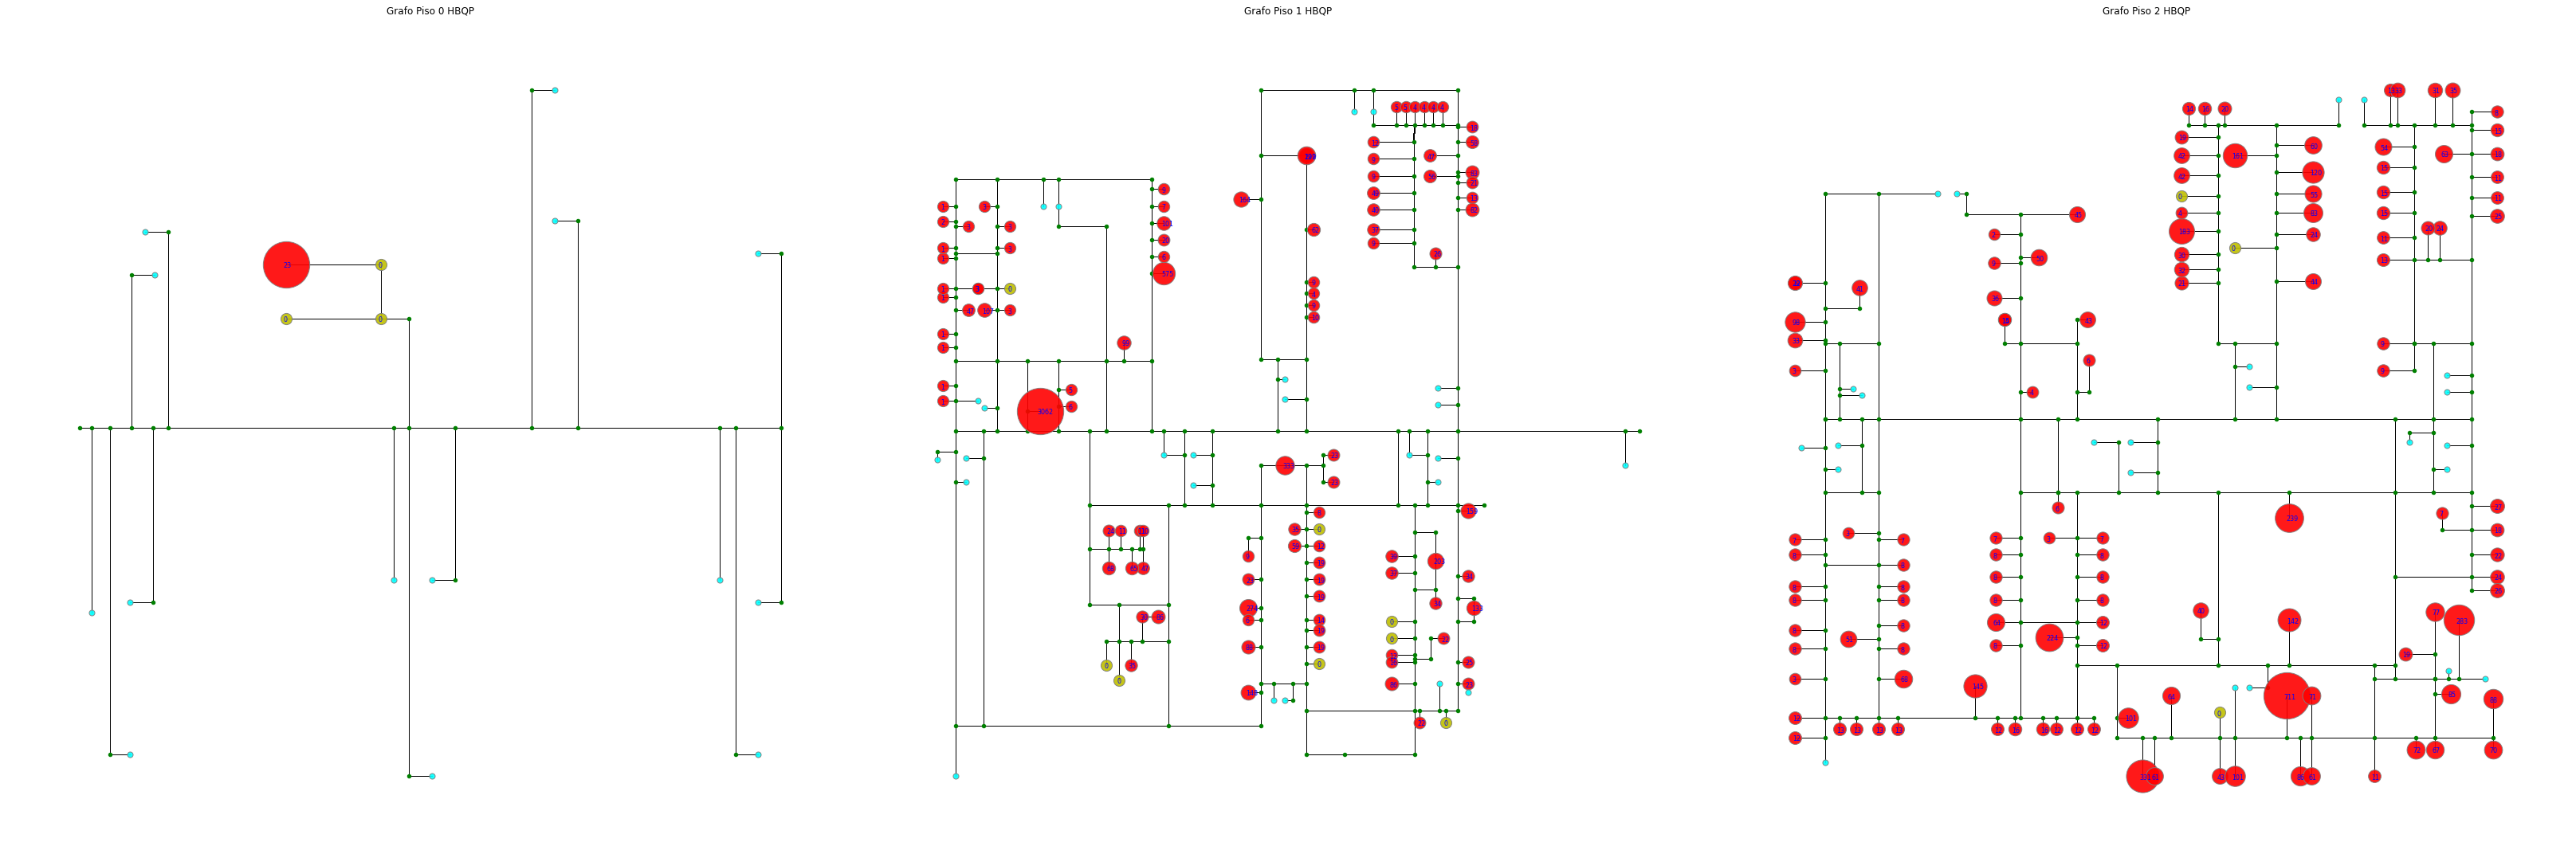

In [64]:
################################################################################
# cual es el piso que deseamos mostrar
pos1, df_nodes1 = posicion(df_nodos, '0')
pos2, df_nodes2 = posicion(df_nodos, '1')
pos3, df_nodes3 = posicion(df_nodos, '2')

################################################################################
# subgrafo solo para los nodos pertenecientes a cada piso selecionado
H1 = G.subgraph(list(df_nodes1.Nodos))
H2 = G.subgraph(list(df_nodes2.Nodos))
H3 = G.subgraph(list(df_nodes3.Nodos))

################################################################################
# vamos a normalizar los valores de la cantidad de equipos por sala para que ###
# los circulos no crescan tanto en el grafico. #################################
################################################################################
c_equipos_norm1, c_equipos1 = normalizacion_cantidad_equipos(H1, df_nodes1, 16)
c_equipos_norm2, c_equipos2 = normalizacion_cantidad_equipos(H2, df_nodes2, 16)
c_equipos_norm3, c_equipos3 = normalizacion_cantidad_equipos(H3, df_nodes3, 16)

################################################################################
# opciones que se repiten en todos los nodos
options = {"edgecolors": "tab:gray", "alpha": 0.9}

################################################################################
# mostramos el grafo  ##########################################################
################################################################################
fig, ax = plt.subplots(1,3,figsize=(45,15))

################################################################################
# GRAFICO PISO 0 ###############################################################
################################################################################
ax[0].set_title('Grafo Piso 0 HBQP') 
# mostramos todos los nodos de los pasillos
nx.draw(H1,pos1, nodelist=list(df_nodes1.Nodos[df_nodes1.Pasillo==1]), node_color = "g", node_size=20, ax = ax[0])
# mostramos todos los nodos de las salas
for idx, indice in enumerate(list(df_nodes1.Nodos[df_nodes1.Sala==1].index)):
    var = c_equipos_norm1[idx]
    if var == 0:
        nx.draw(H1, pos1, nodelist=list(df_nodes1.Nodos.iloc[[indice]]), node_color = "y",node_size=200+200*var, **options, ax = ax[0])
    else:
        nx.draw(H1, pos1, nodelist=list(df_nodes1.Nodos.iloc[[indice]]), node_color = "r",node_size=200+200*var, **options, ax = ax[0])
    # mostramos la cantidad de equipos x sala
    ax[0].text(pos1[df_nodes1.Nodos[indice]][0]-2,pos1[df_nodes1.Nodos[indice]][1], s=str(c_equipos1[idx]),fontsize=8, color = 'b',verticalalignment='center_baseline')

# ingresar texto de la sala
#for idx in range(df_nodos_p0.shape[0]):
#    ax[0].text(df_nodos_p0['Cor_tex x'][idx],df_nodos_p0['Cor_tex y'][idx], s=df_nodos_p0['Nodo'][idx],fontsize=10,verticalalignment='center',rotation=df_nodos_p0['rotacion'][idx])

# mostramos todos los nodos de los ascensores y escaleras
nx.draw(H1,pos1, nodelist=list(df_nodes1.Nodos[df_nodes1.Otro==1]), node_color = "cyan",node_size=50, **options, ax = ax[0])

################################################################################
# GRAFICO PISO 1 ###############################################################
################################################################################
ax[1].set_title('Grafo Piso 1 HBQP') 
# mostramos todos los nodos de los pasillos
nx.draw(H2,pos2, nodelist=list(df_nodes2.Nodos[df_nodes2.Pasillo==1]), node_color = "g", node_size=20, ax = ax[1])
# mostramos todos los nodos de las salas
for idx, indice in enumerate(list(df_nodes2.Nodos[df_nodes2.Sala==1].index)):
    var = c_equipos_norm2[idx]
    if var == 0:
        nx.draw(H2, pos2, nodelist=list(df_nodes2.Nodos.iloc[[indice]]), node_color = "y",node_size=200+200*var, **options, ax = ax[1])
    else:
        nx.draw(H2, pos2, nodelist=list(df_nodes2.Nodos.iloc[[indice]]), node_color = "r",node_size=200+200*var, **options, ax = ax[1])
    # mostramos la cantidad de equipos x sala
    ax[1].text(pos2[df_nodes2.Nodos[indice]][0]-2,pos2[df_nodes2.Nodos[indice]][1], s=str(c_equipos2[idx]),fontsize=8, color = 'b',verticalalignment='center_baseline')

# ingresar texto de la sala
#for idx in range(df_nodos_p1.shape[0]):
#    ax[1].text(df_nodos_p1['Cor_tex x'][idx],df_nodos_p1['Cor_tex y'][idx], s=df_nodos_p1['Nodo'][idx],fontsize=10,verticalalignment='center',rotation=df_nodos_p1['rotacion'][idx])

# mostramos todos los nodos de los ascensores y escaleras
nx.draw(H2,pos2, nodelist=list(df_nodes2.Nodos[df_nodes2.Otro==1]), node_color = "cyan",node_size=50, **options, ax = ax[1])

################################################################################
# GRAFICO PISO 2 ###############################################################
################################################################################
ax[2].set_title('Grafo Piso 2 HBQP') 
# mostramos todos los nodos de los pasillos
nx.draw(H3,pos3, nodelist=list(df_nodes3.Nodos[df_nodes3.Pasillo==1]), node_color = "g", node_size=20, ax = ax[2])
# mostramos todos los nodos de las salas
for idx, indice in enumerate(list(df_nodes3.Nodos[df_nodes3.Sala==1].index)):
    var = c_equipos_norm3[idx]
    if var == 0:
        nx.draw(H3, pos3, nodelist=list(df_nodes3.Nodos.iloc[[indice]]), node_color = "y",node_size=200+200*var, **options, ax = ax[2])
    else:
        nx.draw(H3, pos3, nodelist=list(df_nodes3.Nodos.iloc[[indice]]), node_color = "r",node_size=200+200*var, **options, ax = ax[2])
    # mostramos la cantidad de equipos x sala
    ax[2].text(pos3[df_nodes3.Nodos[indice]][0]-2,pos3[df_nodes3.Nodos[indice]][1], s=str(c_equipos3[idx]),fontsize=8, color = 'b',verticalalignment='center_baseline')

# ingresar texto de la sala
#for idx in range(df_nodos_p2.shape[0]):
#    ax[2].text(df_nodos_p2['Cor_tex x'][idx],df_nodos_p2['Cor_tex y'][idx], s=df_nodos_p2['Nodo'][idx],fontsize=10,verticalalignment='center',rotation=df_nodos_p2['rotacion'][idx])

# mostramos todos los nodos de los ascensores y escaleras
nx.draw(H3,pos3, nodelist=list(df_nodes3.Nodos[df_nodes3.Otro==1]), node_color = "cyan",node_size=50, **options, ax = ax[2])

################################################################################
plt.tight_layout()
plt.show()

## Grafo Trayectorias múltiples- pisos subterráneo, uno y dos

In [35]:
# lugar de donde movere el equipo
G.nodes['C-S1-1']

{'Planta': [1.0, 0.0, 0.0],
 'Equipo-1': 'amperimetro',
 'Marca-1': 'fluke',
 'Modelo-1': 's/m',
 'NSerie-1': 's/n',
 'NInventario-1': '8-81',
 'Mantencion-1': NaT,
 'FreqMantencion-1': 'no aplica',
 'LimiteGarantia-1': Timestamp('2025-04-29 00:00:00'),
 'Equipo-2': 'amperimetro',
 'Marca-2': 'fluke',
 'Modelo-2': 's/m',
 'NSerie-2': 's/n',
 'NInventario-2': '8-82',
 'Mantencion-2': NaT,
 'FreqMantencion-2': 'no aplica',
 'LimiteGarantia-2': Timestamp('2025-04-29 00:00:00'),
 'Equipo-3': 'amperimetro',
 'Marca-3': 'fluke',
 'Modelo-3': 's/m',
 'NSerie-3': 's/n',
 'NInventario-3': '8-83',
 'Mantencion-3': NaT,
 'FreqMantencion-3': 'no aplica',
 'LimiteGarantia-3': Timestamp('2025-04-29 00:00:00'),
 'Equipo-4': 'amperimetro',
 'Marca-4': 'fluke',
 'Modelo-4': 's/m',
 'NSerie-4': 's/n',
 'NInventario-4': '8-84',
 'Mantencion-4': NaT,
 'FreqMantencion-4': 'no aplica',
 'LimiteGarantia-4': Timestamp('2025-04-29 00:00:00'),
 'Equipo-5': 'amperimetro',
 'Marca-5': 'fluke',
 'Modelo-5': 's/m',

In [36]:
# lugar al que llevare el equipo
G.nodes['E-2-6']

{'Planta': [0.0, 0.0, 1.0],
 'Equipo-1': 'biombo de 2 cuerpos',
 'Marca-1': 'medex',
 'Modelo-1': 'biombo 2 cuerpos',
 'NSerie-1': 's/n',
 'NInventario-1': '77-8493',
 'Mantencion-1': NaT,
 'FreqMantencion-1': 'no aplica',
 'LimiteGarantia-1': Timestamp('2022-09-07 00:00:00'),
 'Equipo-2': 'camillas ginecológicas',
 'Marca-2': 's/m',
 'Modelo-2': 's/m',
 'NSerie-2': 's/n',
 'NInventario-2': '149-12945',
 'Mantencion-2': NaT,
 'FreqMantencion-2': 'no aplica',
 'LimiteGarantia-2': Timestamp('2023-08-10 00:00:00'),
 'Equipo-3': 'camillas ginecológicas',
 'Marca-3': 's/m',
 'Modelo-3': 's/m',
 'NSerie-3': 's/n',
 'NInventario-3': '149-12946',
 'Mantencion-3': NaT,
 'FreqMantencion-3': 'no aplica',
 'LimiteGarantia-3': Timestamp('2023-08-10 00:00:00'),
 'Equipo-4': 'detector de latidos cardiofetal',
 'Marca-4': 'edan',
 'Modelo-4': '12.01.210722',
 'NSerie-4': 's/n',
 'NInventario-4': '269-16870',
 'Mantencion-4': Timestamp('2023-10-12 00:00:00'),
 'FreqMantencion-4': 'anual',
 'LimiteGaran

In [37]:
################################################################################
def move_equipment(G, sala1, sala2, eq_name):

  # si suponemos que movemos un equipo medico de la sala1 a sala2
  camino = nx.shortest_path(G,sala1, sala2, weight = 'distancia')
  #camino = nx.shortest_path(G,sala1, sala2)
  edges = [(camino[i], camino[i+1]) for i in range(len(camino)-1)]

  # evaluamos la cantidad de equipos en cada una  de las salas
  s = pd.Series(G.nodes[sala1].keys())
  out = s.str.findall('Equipo')
  cantidad_de_equipos1 = len([1 for n in out if n])

  s = pd.Series(G.nodes[sala2].keys())
  out = s.str.findall('Equipo')
  cantidad_de_equipos2 = len([1 for n in out if n])

  print('Cantidad equipos sala 1: ', cantidad_de_equipos1)
  print('Cantidad equipos sala 2: ', cantidad_de_equipos2)

  # movemos el equipo 1 de la sala 1 a la sala 6
  nombre_eq = eq_name
  number_eq = int(nombre_eq[-1])

  ##############################################################################
  # movemos los atributos creando un diccionario
  d1 = G.nodes[sala2]
  d2 = {}
  d2['Equipo-{0}'.format(cantidad_de_equipos2 + 1)] = G.nodes[sala1]['Equipo-'+str(number_eq)]
  d2['Marca-{0}'.format(cantidad_de_equipos2 + 1)] = G.nodes[sala1]['Marca-'+str(number_eq)]
  d2['Modelo-{0}'.format(cantidad_de_equipos2 + 1)] = G.nodes[sala1]['Modelo-'+str(number_eq)]
  d2['NSerie-{0}'.format(cantidad_de_equipos2 + 1)] = G.nodes[sala1]['NSerie-'+str(number_eq)]
  d2['NInventario-{0}'.format(cantidad_de_equipos2 + 1)] = G.nodes[sala1]['NInventario-'+str(number_eq)]
  d2['Mantencion-{0}'.format(cantidad_de_equipos2 + 1)] = G.nodes[sala1]['Mantencion-'+str(number_eq)]
  d2['FreqMantencion-{0}'.format(cantidad_de_equipos2 + 1)] = G.nodes[sala1]['FreqMantencion-'+str(number_eq)]
  d2['LimiteGarantia-{0}'.format(cantidad_de_equipos2 + 1)] = G.nodes[sala1]['LimiteGarantia-'+str(number_eq)]
  d1.update(d2)

  attrs = {sala2 : d1}
  # asignamos solo los atributos de la sala 2
  nx.set_node_attributes(G, attrs)

  # eliminamos los nodos de la sala correspondiente.
  del G.nodes[sala1]['Equipo-' + str(number_eq)]
  del G.nodes[sala1]['Marca-' + str(number_eq)]
  del G.nodes[sala1]['Modelo-' + str(number_eq)]
  del G.nodes[sala1]['NSerie-' + str(number_eq)]
  del G.nodes[sala1]['NInventario-' + str(number_eq)]
  del G.nodes[sala1]['Mantencion-' + str(number_eq)]
  del G.nodes[sala1]['FreqMantencion-' + str(number_eq)]
  del G.nodes[sala1]['LimiteGarantia-' + str(number_eq)]

  #print(G.nodes[sala1])

  ##############################################################################
  if cantidad_de_equipos1>1:
    d1 = G.nodes[sala1].copy()
    del d1['Planta']
    var = list(d1.keys())
    cont = 0
    for n in range(cantidad_de_equipos1-1):
      for m in range(8):
        del G.nodes[sala1][var[cont]]
        # debemos renombrar los equipos dentro de la sala
        d1[var[cont].split('-')[0]+'-'+str(n+1)] = d1.pop(var[cont])
        cont +=1

    attrs = {sala1 : d1}
    nx.set_node_attributes(G, attrs)

  return G, edges

In [38]:
G, edges1 = move_equipment(G, 'C-S1-1', 'E-2-6', 'Equipo-1')
G, edges2 = move_equipment(G, 'C-S1-1', 'D-1-6', 'Equipo-1')
G, edges3 = move_equipment(G, 'C-S1-1', 'H-1-20', 'Equipo-1')
G, edges4 = move_equipment(G, 'C-S1-1', 'E-1-55', 'Equipo-1')
G, edges5 = move_equipment(G, 'C-S1-1', 'J-1-55', 'Equipo-1')
G, edges6 = move_equipment(G, 'C-S1-1', 'C-2-12', 'Equipo-1')
G, edges7 = move_equipment(G, 'C-S1-1', 'B-2-4', 'Equipo-1')

Cantidad equipos sala 1:  30
Cantidad equipos sala 2:  14
Cantidad equipos sala 1:  29
Cantidad equipos sala 2:  9
Cantidad equipos sala 1:  28
Cantidad equipos sala 2:  23
Cantidad equipos sala 1:  27
Cantidad equipos sala 2:  25
Cantidad equipos sala 1:  26
Cantidad equipos sala 2:  21
Cantidad equipos sala 1:  25
Cantidad equipos sala 2:  3
Cantidad equipos sala 1:  24
Cantidad equipos sala 2:  32


In [39]:
# lugar de donde movere el equipo
G.nodes['C-S1-1']

{'Planta': [1.0, 0.0, 0.0],
 'Equipo-1': 'amperimetro',
 'Marca-1': 'fluke',
 'Modelo-1': 's/m',
 'NSerie-1': 's/n',
 'NInventario-1': '8-88',
 'Mantencion-1': NaT,
 'FreqMantencion-1': 'no aplica',
 'LimiteGarantia-1': Timestamp('2025-04-29 00:00:00'),
 'Equipo-2': 'amperimetro',
 'Marca-2': 'fluke',
 'Modelo-2': 's/m',
 'NSerie-2': 's/n',
 'NInventario-2': '8-89',
 'Mantencion-2': NaT,
 'FreqMantencion-2': 'no aplica',
 'LimiteGarantia-2': Timestamp('2025-04-29 00:00:00'),
 'Equipo-3': 'amperimetro',
 'Marca-3': 'fluke',
 'Modelo-3': nan,
 'NSerie-3': '55311277mv',
 'NInventario-3': '8-92',
 'Mantencion-3': Timestamp('2023-04-29 00:00:00'),
 'FreqMantencion-3': 'anual',
 'LimiteGarantia-3': Timestamp('2025-04-29 00:00:00'),
 'Equipo-4': 'basurero 20-25 litros',
 'Marca-4': 'kendy',
 'Modelo-4': '20lts',
 'NSerie-4': 's/n',
 'NInventario-4': '62-7115',
 'Mantencion-4': NaT,
 'FreqMantencion-4': 'no aplica',
 'LimiteGarantia-4': Timestamp('2022-04-01 00:00:00'),
 'Equipo-5': 'luxometro

In [40]:
# lugar al que llevare el equipo
G.nodes['E-2-6']

{'Planta': [0.0, 0.0, 1.0],
 'Equipo-1': 'biombo de 2 cuerpos',
 'Marca-1': 'medex',
 'Modelo-1': 'biombo 2 cuerpos',
 'NSerie-1': 's/n',
 'NInventario-1': '77-8493',
 'Mantencion-1': NaT,
 'FreqMantencion-1': 'no aplica',
 'LimiteGarantia-1': Timestamp('2022-09-07 00:00:00'),
 'Equipo-2': 'camillas ginecológicas',
 'Marca-2': 's/m',
 'Modelo-2': 's/m',
 'NSerie-2': 's/n',
 'NInventario-2': '149-12945',
 'Mantencion-2': NaT,
 'FreqMantencion-2': 'no aplica',
 'LimiteGarantia-2': Timestamp('2023-08-10 00:00:00'),
 'Equipo-3': 'camillas ginecológicas',
 'Marca-3': 's/m',
 'Modelo-3': 's/m',
 'NSerie-3': 's/n',
 'NInventario-3': '149-12946',
 'Mantencion-3': NaT,
 'FreqMantencion-3': 'no aplica',
 'LimiteGarantia-3': Timestamp('2023-08-10 00:00:00'),
 'Equipo-4': 'detector de latidos cardiofetal',
 'Marca-4': 'edan',
 'Modelo-4': '12.01.210722',
 'NSerie-4': 's/n',
 'NInventario-4': '269-16870',
 'Mantencion-4': Timestamp('2023-10-12 00:00:00'),
 'FreqMantencion-4': 'anual',
 'LimiteGaran

In [41]:
def camino(edges, H1, H2, H3):
  list_p1 = []
  list_p2 = []
  list_p3 = []
  for tup in edges:
    if H1.has_node(tup[0]) and H1.has_node(tup[1]):
      list_p1.append(tup)
    if H2.has_node(tup[0]) and H2.has_node(tup[1]):
      list_p2.append(tup)
    if H3.has_node(tup[0]) and H3.has_node(tup[1]):
      list_p3.append(tup)

  return list_p1, list_p2, list_p3

In [42]:
list_p01, list_p11, list_p21 = camino(edges1, H1, H2, H3)
list_p02, list_p12, list_p22 = camino(edges2, H1, H2, H3)
list_p03, list_p13, list_p23 = camino(edges3, H1, H2, H3)
list_p04, list_p14, list_p24 = camino(edges4, H1, H2, H3)
list_p05, list_p15, list_p25 = camino(edges5, H1, H2, H3)
list_p06, list_p16, list_p26 = camino(edges6, H1, H2, H3)
list_p07, list_p17, list_p27 = camino(edges7, H1, H2, H3)

list_p0 = [list_p01,list_p02,list_p03,list_p04,list_p05,list_p06,list_p07]
list_p1 = [list_p11,list_p12,list_p13,list_p14,list_p15,list_p16,list_p17]
list_p2 = [list_p21,list_p22,list_p23,list_p24,list_p25,list_p26,list_p27]

ww = np.flip(np.linspace(3,7,len(list_p0)))


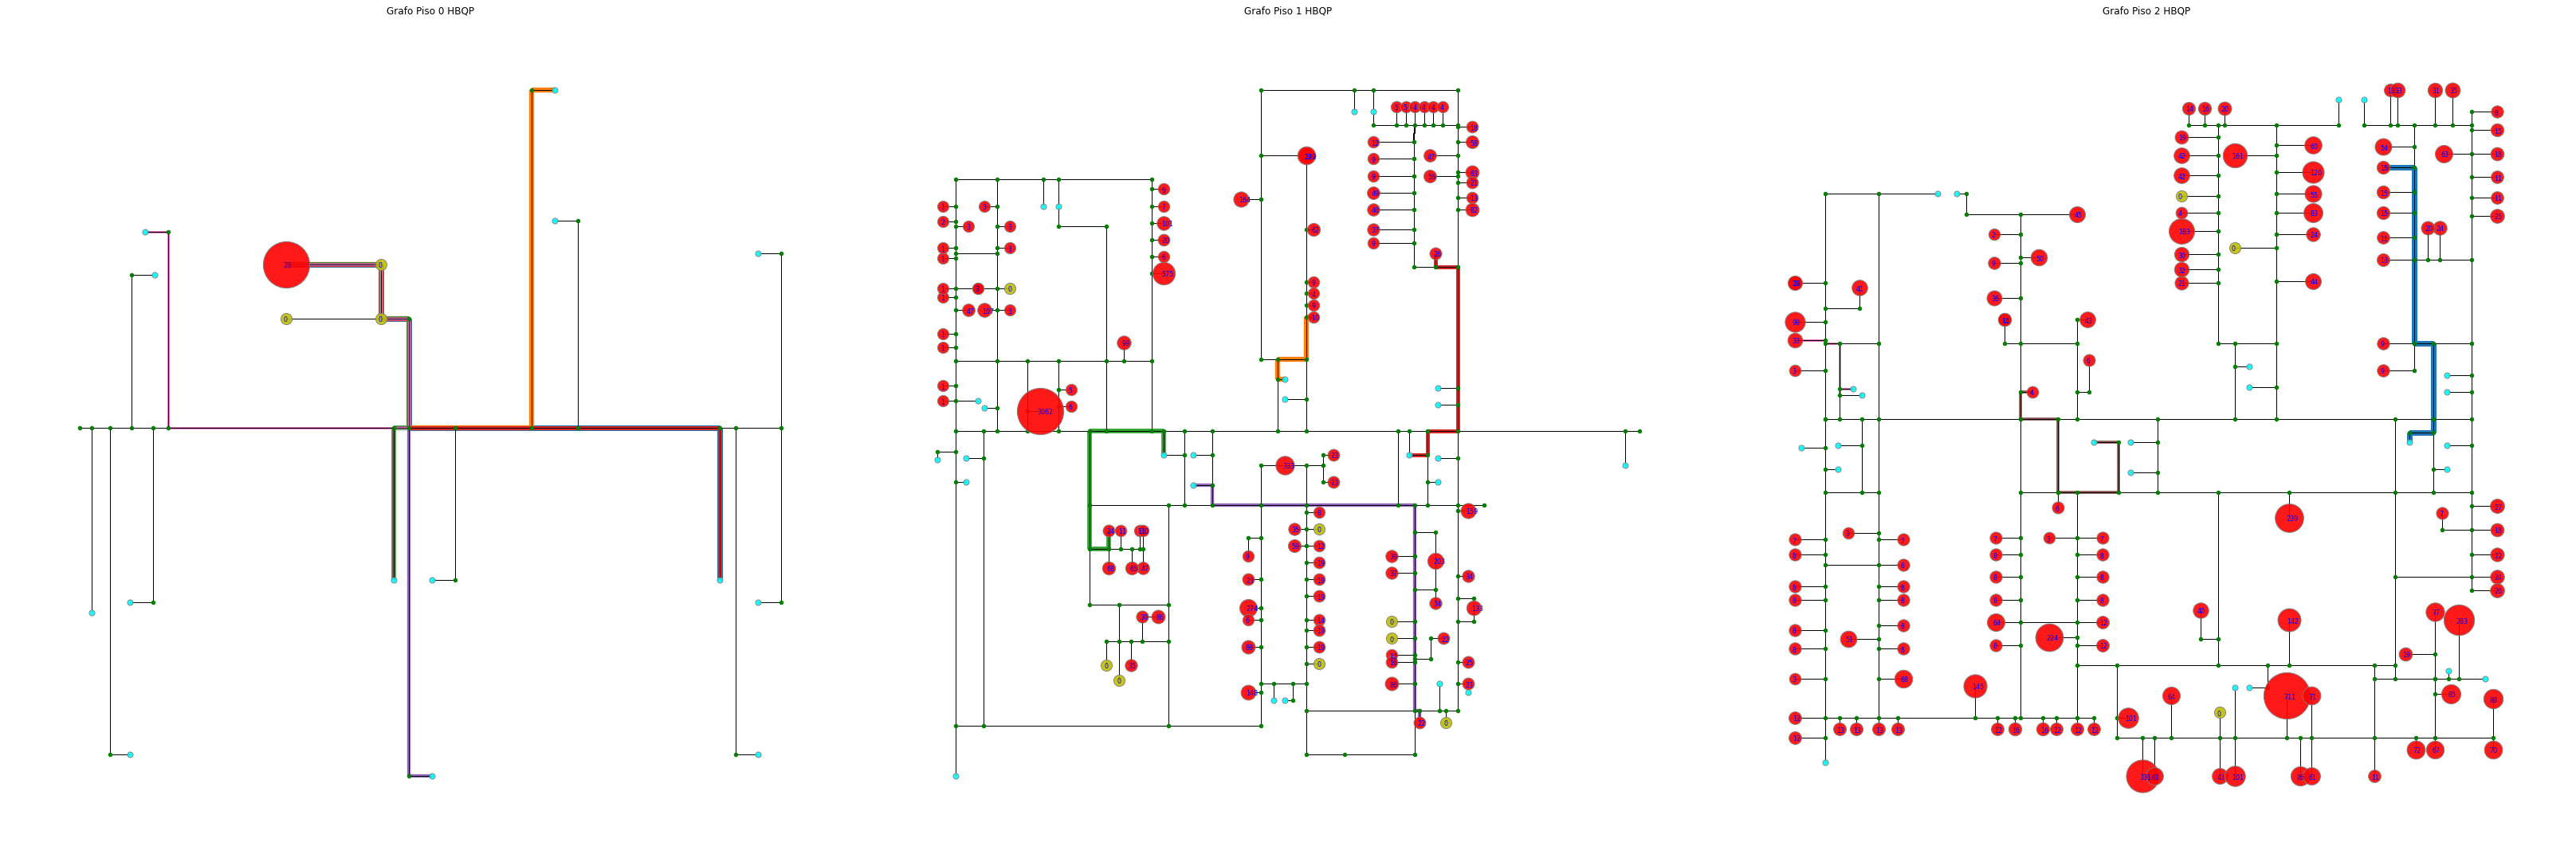

In [44]:
################################################################################
# cual es el piso que deseamos mostrar
pos1, df_nodes1 = posicion(df_nodos, '0')
pos2, df_nodes2 = posicion(df_nodos, '1')
pos3, df_nodes3 = posicion(df_nodos, '2')

################################################################################
# subgrafo solo para los nodos pertenecientes a cada piso selecionado
H1 = G.subgraph(list(df_nodes1.Nodos))
H2 = G.subgraph(list(df_nodes2.Nodos))
H3 = G.subgraph(list(df_nodes3.Nodos))

################################################################################
# vamos a normalizar los valores de la cantidad de equipos por sala para que ###
# los circulos no crescan tanto en el grafico. #################################
################################################################################
c_equipos_norm1, c_equipos1 = normalizacion_cantidad_equipos(H1, df_nodes1, 16)
c_equipos_norm2, c_equipos2 = normalizacion_cantidad_equipos(H2, df_nodes2, 16)
c_equipos_norm3, c_equipos3 = normalizacion_cantidad_equipos(H3, df_nodes3, 16)

################################################################################
# opciones que se repiten en todos los nodos
options = {"edgecolors": "tab:gray", "alpha": 0.9}

################################################################################
# mostramos el grafo  ##########################################################
################################################################################
fig, ax = plt.subplots(1,3,figsize=(45,15))

################################################################################
# GRAFICO PISO 0 ###############################################################
################################################################################
ax[0].set_title('Grafo Piso 0 HBQP') 
# mostramos todos los nodos de los pasillos
nx.draw(H1,pos1, nodelist=list(df_nodes1.Nodos[df_nodes1.Pasillo==1]), node_color = "g", node_size=20, ax = ax[0])


names = list(mcolors.TABLEAU_COLORS)
colores = mcolors.TABLEAU_COLORS
for idx, ll in enumerate(list_p0):
  if ll:
    nx.draw_networkx_edges(H1,pos1,edgelist = ll, edge_color=colores[names[idx]], width=ww[idx],ax = ax[0])

# mostramos todos los nodos de las salas
for idx, indice in enumerate(list(df_nodes1.Nodos[df_nodes1.Sala==1].index)):
    var = c_equipos_norm1[idx]
    if var == 0:
        nx.draw(H1, pos1, nodelist=list(df_nodes1.Nodos.iloc[[indice]]), node_color = "y",node_size=200+200*var, **options, ax = ax[0])
    else:
        nx.draw(H1, pos1, nodelist=list(df_nodes1.Nodos.iloc[[indice]]), node_color = "r",node_size=200+200*var, **options, ax = ax[0])
    # mostramos la cantidad de equipos x sala
    ax[0].text(pos1[df_nodes1.Nodos[indice]][0]-2,pos1[df_nodes1.Nodos[indice]][1], s=str(c_equipos1[idx]),fontsize=8, color = 'b',verticalalignment='center_baseline')
# mostramos todos los nodos de los ascensores y escaleras
nx.draw(H1,pos1, nodelist=list(df_nodes1.Nodos[df_nodes1.Otro==1]), node_color = "cyan",node_size=50, **options, ax = ax[0])

################################################################################
# GRAFICO PISO 1 ###############################################################
################################################################################
ax[1].set_title('Grafo Piso 1 HBQP') 
# mostramos todos los nodos de los pasillos
nx.draw(H2,pos2, nodelist=list(df_nodes2.Nodos[df_nodes2.Pasillo==1]), node_color = "g", node_size=20, ax = ax[1])

names = list(mcolors.TABLEAU_COLORS)
colores = mcolors.TABLEAU_COLORS
for idx, ll in enumerate(list_p1):
  if ll:
    nx.draw_networkx_edges(H2,pos2,edgelist = ll, edge_color=colores[names[idx]], width=ww[idx],ax = ax[1])

# mostramos todos los nodos de las salas
for idx, indice in enumerate(list(df_nodes2.Nodos[df_nodes2.Sala==1].index)):
    var = c_equipos_norm2[idx]
    if var == 0:
        nx.draw(H2, pos2, nodelist=list(df_nodes2.Nodos.iloc[[indice]]), node_color = "y",node_size=200+200*var, **options, ax = ax[1])
    else:
        nx.draw(H2, pos2, nodelist=list(df_nodes2.Nodos.iloc[[indice]]), node_color = "r",node_size=200+200*var, **options, ax = ax[1])
    # mostramos la cantidad de equipos x sala
    ax[1].text(pos2[df_nodes2.Nodos[indice]][0]-2,pos2[df_nodes2.Nodos[indice]][1], s=str(c_equipos2[idx]),fontsize=8, color = 'b',verticalalignment='center_baseline')
# mostramos todos los nodos de los ascensores y escaleras
nx.draw(H2,pos2, nodelist=list(df_nodes2.Nodos[df_nodes2.Otro==1]), node_color = "cyan",node_size=50, **options, ax = ax[1])

################################################################################
# GRAFICO PISO 2 ###############################################################
################################################################################
ax[2].set_title('Grafo Piso 2 HBQP') 
# mostramos todos los nodos de los pasillos
nx.draw(H3,pos3, nodelist=list(df_nodes3.Nodos[df_nodes3.Pasillo==1]), node_color = "g", node_size=20, ax = ax[2])

names = list(mcolors.TABLEAU_COLORS)
colores = mcolors.TABLEAU_COLORS
for idx, ll in enumerate(list_p2):
  if ll:
    nx.draw_networkx_edges(H3,pos3,edgelist = ll, edge_color=colores[names[idx]], width=ww[idx],ax = ax[2])

# mostramos todos los nodos de las salas
for idx, indice in enumerate(list(df_nodes3.Nodos[df_nodes3.Sala==1].index)):
    var = c_equipos_norm3[idx]
    if var == 0:
        nx.draw(H3, pos3, nodelist=list(df_nodes3.Nodos.iloc[[indice]]), node_color = "y",node_size=200+200*var, **options, ax = ax[2])
    else:
        nx.draw(H3, pos3, nodelist=list(df_nodes3.Nodos.iloc[[indice]]), node_color = "r",node_size=200+200*var, **options, ax = ax[2])
    # mostramos la cantidad de equipos x sala
    ax[2].text(pos3[df_nodes3.Nodos[indice]][0]-2,pos3[df_nodes3.Nodos[indice]][1], s=str(c_equipos3[idx]),fontsize=8, color = 'b',verticalalignment='center_baseline')
# mostramos todos los nodos de los ascensores y escaleras
nx.draw(H3,pos3, nodelist=list(df_nodes3.Nodos[df_nodes3.Otro==1]), node_color = "cyan",node_size=50, **options, ax = ax[2])

################################################################################
plt.tight_layout()
plt.show()


In [65]:
#edges1

In [46]:
# para calcular la distancia podemos usar los atributos de los enlaces
distancia_total1 = 0
for nod1,nod2 in edges1:
  distancia_total1 += G.edges[nod1, nod2]['distancia']

distancia_total2 = 0
for nod1,nod2 in edges2:
  distancia_total2 += G.edges[nod1, nod2]['distancia']

distancia_total3 = 0
for nod1,nod2 in edges3:
  distancia_total3 += G.edges[nod1, nod2]['distancia']

distancia_total4 = 0
for nod1,nod2 in edges4:
  distancia_total4 += G.edges[nod1, nod2]['distancia']

distancia_total5 = 0
for nod1,nod2 in edges5:
  distancia_total5 += G.edges[nod1, nod2]['distancia']

distancia_total6 = 0
for nod1,nod2 in edges6:
  distancia_total6 += G.edges[nod1, nod2]['distancia']

distancia_total7 = 0
for nod1,nod2 in edges7:
  distancia_total7 += G.edges[nod1, nod2]['distancia']

print('La distancia total recorrida 1 por el equipo es {} (m)'.format(distancia_total1))
print('La distancia total recorrida 2 por el equipo es {} (m)'.format(distancia_total2))
print('La distancia total recorrida 3 por el equipo es {} (m)'.format(distancia_total3))
print('La distancia total recorrida 4 por el equipo es {} (m)'.format(distancia_total4))
print('La distancia total recorrida 5 por el equipo es {} (m)'.format(distancia_total5))
print('La distancia total recorrida 6 por el equipo es {} (m)'.format(distancia_total6))
print('La distancia total recorrida 7 por el equipo es {} (m)'.format(distancia_total7))

La distancia total recorrida 1 por el equipo es 526.0 (m)
La distancia total recorrida 2 por el equipo es 295.0 (m)
La distancia total recorrida 3 por el equipo es 296.0 (m)
La distancia total recorrida 4 por el equipo es 493.0 (m)
La distancia total recorrida 5 por el equipo es 480.0 (m)
La distancia total recorrida 6 por el equipo es 300.0 (m)
La distancia total recorrida 7 por el equipo es 361.0 (m)


In [67]:
#G.nodes['E-2-6']

In [66]:
#H1.nodes['C-S1-1']

# Grafo Mantenciones próximas - pisos subterráneo, uno y dos

In [49]:
import datetime
# podemos calcular la fecha actual
res = datetime.datetime.now(pytz.timezone('America/Santiago'))
date1 = pd.Timestamp(datetime.datetime(res.year, res.month, res.day))
print(date1)
date2 = pd.Timestamp(datetime.datetime(2022, 10, 7))
print(date2)
diff = date2 - date1
print(diff.days)

2022-12-22 00:00:00
2022-10-07 00:00:00
-76


<ipython-input-50-f10eeec5fc22>:94: RuntimeWarning: All-NaN slice encountered
  mant_mas_proxima = np.nanmin(delta)
<ipython-input-50-f10eeec5fc22>:134: RuntimeWarning: All-NaN slice encountered
  mant_mas_proxima = np.nanmin(delta)


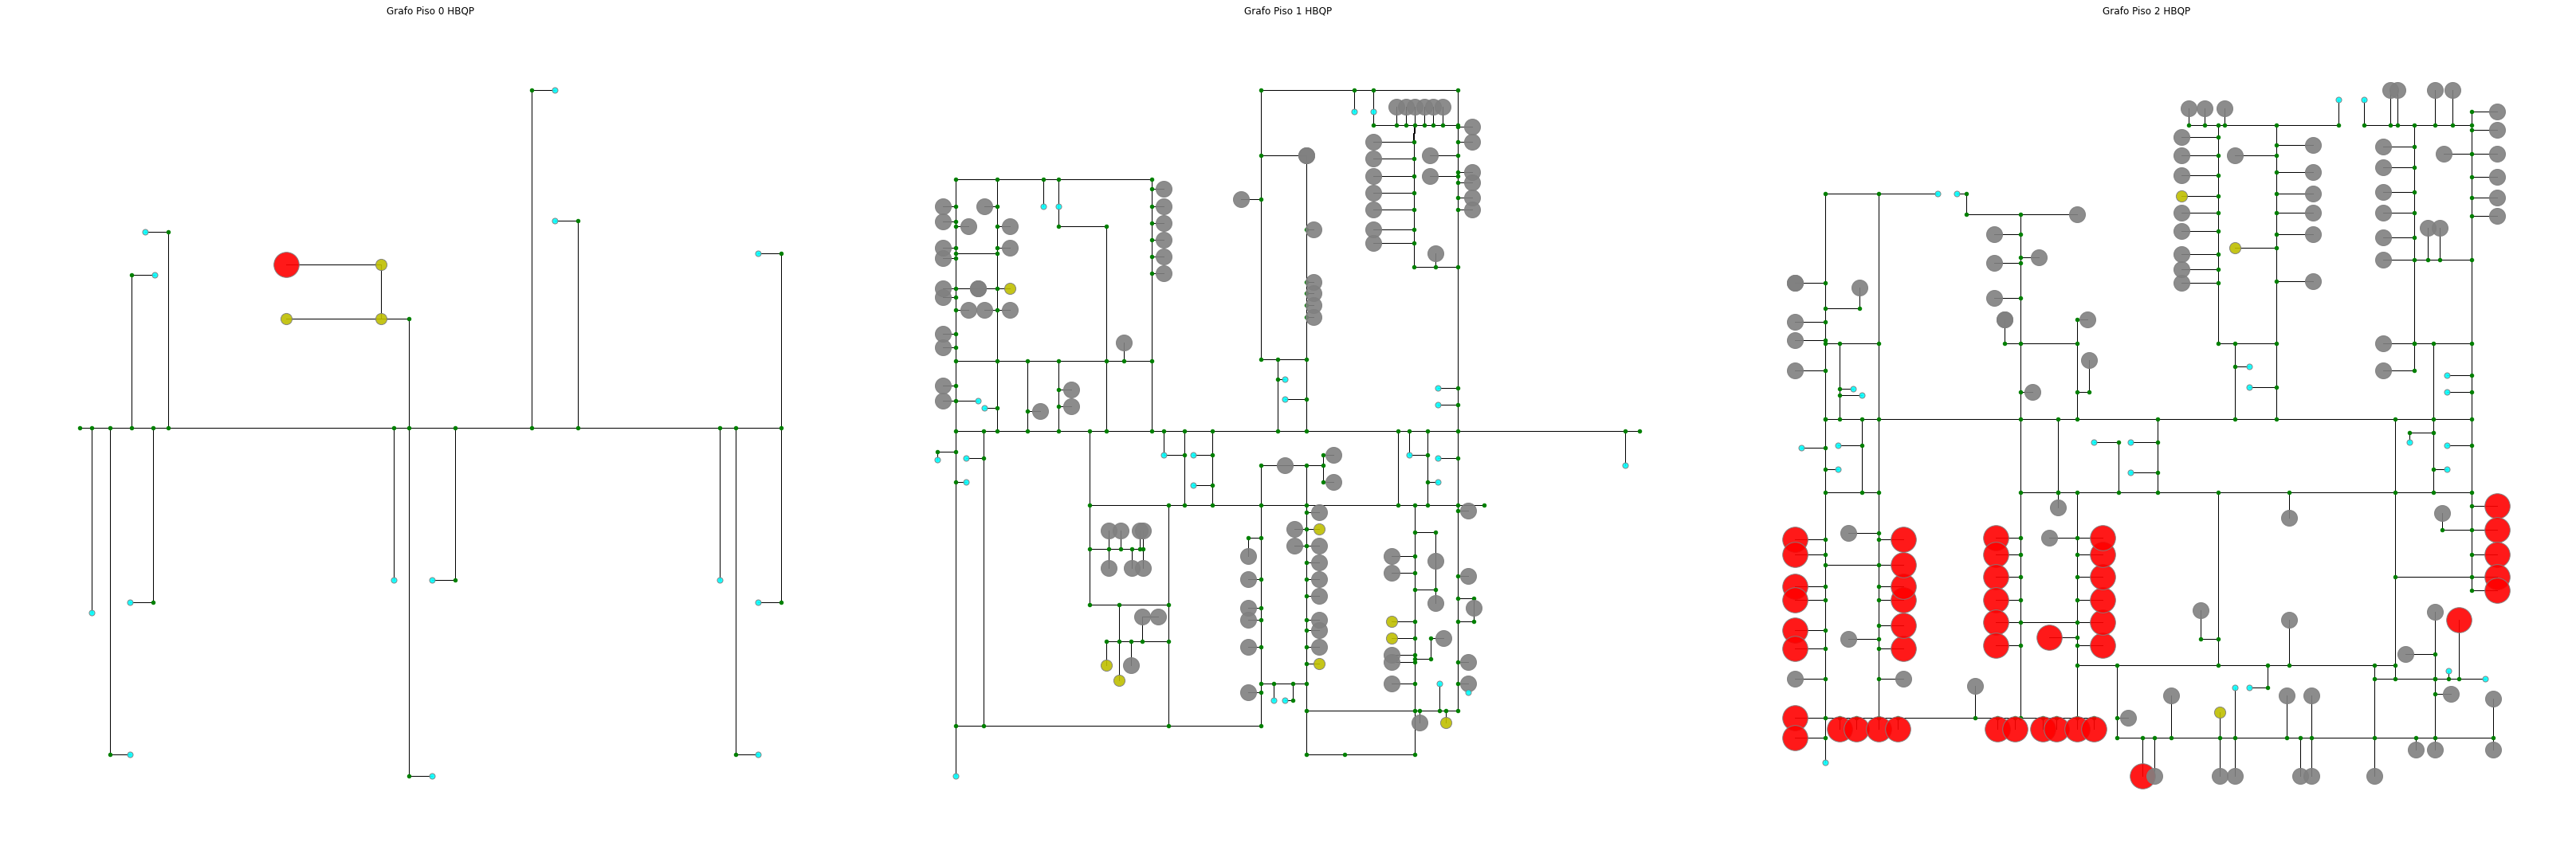

In [50]:
################################################################################
dias_mantencion = 7

################################################################################
# cual es el piso que deseamos mostrar
pos1, df_nodes1 = posicion(df_nodos, '0')
pos2, df_nodes2 = posicion(df_nodos, '1')
pos3, df_nodes3 = posicion(df_nodos, '2')

################################################################################
# subgrafo solo para los nodos pertenecientes a cada piso selecionado
H1 = G.subgraph(list(df_nodes1.Nodos))
H2 = G.subgraph(list(df_nodes2.Nodos))
H3 = G.subgraph(list(df_nodes3.Nodos))

################################################################################
# vamos a normalizar los valores de la cantidad de equipos por sala para que ###
# los circulos no crescan tanto en el grafico. #################################
################################################################################
c_equipos_norm1, c_equipos1 = normalizacion_cantidad_equipos(H1, df_nodes1, 16)
c_equipos_norm2, c_equipos2 = normalizacion_cantidad_equipos(H2, df_nodes2, 16)
c_equipos_norm3, c_equipos3 = normalizacion_cantidad_equipos(H3, df_nodes3, 16)

################################################################################
# opciones que se repiten en todos los nodos
options = {"edgecolors": "tab:gray", "alpha": 0.9}

################################################################################
# mostramos el grafo  ##########################################################
################################################################################
fig, ax = plt.subplots(1,3,figsize=(45,15))

################################################################################
# GRAFICO PISO 0 ###############################################################
################################################################################
ax[0].set_title('Grafo Piso 0 HBQP') 
# mostramos todos los nodos de los pasillos
nx.draw(H1,pos1, nodelist=list(df_nodes1.Nodos[df_nodes1.Pasillo==1]), node_color = "g", node_size=20, ax = ax[0])
#if list_p1:
#  nx.draw_networkx_edges(H1,pos1,edgelist = list_p1, edge_color='blue', width=5,ax = ax[0])
# mostramos todos los nodos de las salas
for idx, indice in enumerate(list(df_nodes1.Nodos[df_nodes1.Sala==1].index)):
    var = c_equipos_norm1[idx]
    if var == 0:
        nx.draw(H1, pos1, nodelist=list(df_nodes1.Nodos.iloc[[indice]]), node_color = "y",node_size=200+200*var, **options, ax = ax[0])
    else:
        #nx.draw(H1, pos1, nodelist=list(df_nodes1.Nodos.iloc[[indice]]), node_color = "r",node_size=200+200*var, **options, ax = ax[0])

        delta = [] 
        for n in range(c_equipos1[idx]):
            date2 = H1.nodes[df_nodes1.Nodos[indice]]['Mantencion-'+str(n+1)]
            diff = date2 - date1
            delta.append(diff.days)
        delta = np.array(delta)
        mant_mas_proxima = np.nanmin(delta)

        # si el equipo necesita mantencion durante esta semana
        if mant_mas_proxima<dias_mantencion and mant_mas_proxima>0:
            nx.draw(H1,pos1, nodelist=list(df_nodes1.Nodos.iloc[[indice]]), node_color='#ff0000',node_size=200+200*4, **options, ax = ax[0])# rojo
        # si se paso la mantencion del equipo
        elif mant_mas_proxima<=0 :
            nx.draw(H1,pos1, nodelist=list(df_nodes1.Nodos.iloc[[indice]]), node_color ='#660000',node_size=200+200*4, **options, ax = ax[0])# burdeo
        # el equipo no necesita mantencion esta semana
        else:
            nx.draw(H1,pos1, nodelist=list(df_nodes1.Nodos.iloc[[indice]]), node_color = "gray",node_size=200+200, **options, ax = ax[0])# gris

    # mostramos la cantidad de equipos x sala
    #ax[0].text(pos1[df_nodes1.Nodos[indice]][0]-2,pos1[df_nodes1.Nodos[indice]][1], s=str(c_equipos1[idx]),fontsize=8, color = 'b',verticalalignment='center_baseline')
# mostramos todos los nodos de los ascensores y escaleras
nx.draw(H1,pos1, nodelist=list(df_nodes1.Nodos[df_nodes1.Otro==1]), node_color = "cyan",node_size=50, **options, ax = ax[0])

################################################################################
# GRAFICO PISO 1 ###############################################################
################################################################################
ax[1].set_title('Grafo Piso 1 HBQP') 
# mostramos todos los nodos de los pasillos
nx.draw(H2,pos2, nodelist=list(df_nodes2.Nodos[df_nodes2.Pasillo==1]), node_color = "g", node_size=20, ax = ax[1])
#if list_p2:
#  nx.draw_networkx_edges(H2,pos2,edgelist = list_p2, edge_color='blue', width=5,ax = ax[1])
# mostramos todos los nodos de las salas
for idx, indice in enumerate(list(df_nodes2.Nodos[df_nodes2.Sala==1].index)):
    var = c_equipos_norm2[idx]
    if var == 0:
        nx.draw(H2, pos2, nodelist=list(df_nodes2.Nodos.iloc[[indice]]), node_color = "y",node_size=200+200*var, **options, ax = ax[1])
    else:
        #nx.draw(H2, pos2, nodelist=list(df_nodes2.Nodos.iloc[[indice]]), node_color = "r",node_size=200+200*var, **options, ax = ax[1])

        delta = [] 
        for n in range(c_equipos2[idx]):
            date2 = H2.nodes[df_nodes2.Nodos[indice]]['Mantencion-'+str(n+1)]
            diff = date2 - date1
            delta.append(diff.days)
        delta = np.array(delta)
        mant_mas_proxima = np.nanmin(delta)

        # si el equipo necesita mantencion durante esta semana
        if mant_mas_proxima<dias_mantencion and mant_mas_proxima>0:
            nx.draw(H2,pos2, nodelist=list(df_nodes2.Nodos.iloc[[indice]]), node_color='#ff0000',node_size=200+200*4, **options, ax = ax[1])# rojo
        # si se paso la mantencion del equipo
        elif mant_mas_proxima<=0 :
            nx.draw(H2,pos2, nodelist=list(df_nodes2.Nodos.iloc[[indice]]), node_color ='#660000',node_size=200+200*4, **options, ax = ax[1])# burdeo
        # el equipo no necesita mantencion esta semana
        else:
            nx.draw(H2,pos2, nodelist=list(df_nodes2.Nodos.iloc[[indice]]), node_color = "gray",node_size=200+200, **options, ax = ax[1])# gris


    # mostramos la cantidad de equipos x sala
    #ax[1].text(pos2[df_nodes2.Nodos[indice]][0]-2,pos2[df_nodes2.Nodos[indice]][1], s=str(c_equipos2[idx]),fontsize=8, color = 'b',verticalalignment='center_baseline')
# mostramos todos los nodos de los ascensores y escaleras
nx.draw(H2,pos2, nodelist=list(df_nodes2.Nodos[df_nodes2.Otro==1]), node_color = "cyan",node_size=50, **options, ax = ax[1])

################################################################################
# GRAFICO PISO 2 ###############################################################
################################################################################
ax[2].set_title('Grafo Piso 2 HBQP') 
# mostramos todos los nodos de los pasillos
nx.draw(H3,pos3, nodelist=list(df_nodes3.Nodos[df_nodes3.Pasillo==1]), node_color = "g", node_size=20, ax = ax[2])
#if list_p3:
#  nx.draw_networkx_edges(H3,pos3,edgelist = list_p3, edge_color='blue', width=5,ax = ax[2])
# mostramos todos los nodos de las salas
for idx, indice in enumerate(list(df_nodes3.Nodos[df_nodes3.Sala==1].index)):
    var = c_equipos_norm3[idx]
    if var == 0:
        nx.draw(H3, pos3, nodelist=list(df_nodes3.Nodos.iloc[[indice]]), node_color = "y",node_size=200+200*var, **options, ax = ax[2])
    else:
        #nx.draw(H3, pos3, nodelist=list(df_nodes3.Nodos.iloc[[indice]]), node_color = "r",node_size=200+200*var, **options, ax = ax[2])

        delta = [] 
        for n in range(c_equipos3[idx]):
            date2 = H3.nodes[df_nodes3.Nodos[indice]]['Mantencion-'+str(n+1)]
            diff = date2 - date1
            delta.append(diff.days)
        delta = np.array(delta)
        mant_mas_proxima = np.nanmin(delta)

        # si el equipo necesita mantencion durante esta semana
        if mant_mas_proxima<dias_mantencion and mant_mas_proxima>0:
            nx.draw(H3,pos3, nodelist=list(df_nodes3.Nodos.iloc[[indice]]), node_color='#ff0000',node_size=200+200*4, **options, ax = ax[2]) # rojo
        # si se paso la mantencion del equipo
        elif mant_mas_proxima<=0 :
            nx.draw(H3,pos3, nodelist=list(df_nodes3.Nodos.iloc[[indice]]), node_color ='#660000',node_size=200+200*4, **options, ax = ax[2]) # burdeo
        # el equipo no necesita mantencion esta semana
        else:
            nx.draw(H3,pos3, nodelist=list(df_nodes3.Nodos.iloc[[indice]]), node_color = "gray",node_size=200+200, **options, ax = ax[2])# gris

    # mostramos la cantidad de equipos x sala
    #ax[2].text(pos3[df_nodes3.Nodos[indice]][0]-2,pos3[df_nodes3.Nodos[indice]][1], s=str(c_equipos3[idx]),fontsize=8, color = 'b',verticalalignment='center_baseline')
# mostramos todos los nodos de los ascensores y escaleras
nx.draw(H3,pos3, nodelist=list(df_nodes3.Nodos[df_nodes3.Otro==1]), node_color = "cyan",node_size=50, **options, ax = ax[2])

################################################################################
plt.tight_layout()
plt.show()

## Creación de Fata Frame de mantenciones, priorizando fechas próximas 

In [51]:
# Generar una data frame solo con la informacion en rojo o burdeo, priorizando la fecha mas proxima. 

# las columnas que debe contener son: Sala, Equipo, Marca, Nserie, Ninventario, Mantencion, Modelo
# en cada fila poner solo la informacion del equipo que necesita mantencion.
# primero los dos equipos que se pasaron de la fecha de mantencion
# despues los equipos que requieren mantencion esta semana (rojo claro)
Sala = []
Dias = []
Equipo = []
Marca = []
Nserie = []
Ninventario = []
Mantencion = []
Modelo = []

for idx, indice in enumerate(list(df_nodes1.Nodos[df_nodes1.Sala==1].index)):
#for idx in range(df_nodes.Nodos[:87].shape[0]):
    s = pd.Series(H1.nodes[df_nodes1.Nodos[indice]].keys())
    out = s.str.findall('Equipo')
    var = len([1 for n in out if n])
    if var > 0:
        delta = [] 
        for n in range(var):
            date2 = H1.nodes[df_nodes1.Nodos[indice]]['Mantencion-'+str(n+1)]
            diff = date2 - date1
            delta.append(diff.days)
        delta = np.array(delta)

        #######################################################################
        for index, value in enumerate(delta):
          if value<7:
            Sala.append(df_nodes1.Nodos[indice])
            Dias.append(value)
            Equipo.append(H1.nodes[df_nodes1.Nodos[indice]]['Equipo-'+str(index+1)])
            Marca.append(H1.nodes[df_nodes1.Nodos[indice]]['Marca-'+str(index+1)])
            Nserie.append(H1.nodes[df_nodes1.Nodos[indice]]['NSerie-'+str(index+1)])
            Ninventario.append(H1.nodes[df_nodes1.Nodos[indice]]['NInventario-'+str(index+1)])
            Mantencion.append(H1.nodes[df_nodes1.Nodos[indice]]['Mantencion-'+str(index+1)])
            Modelo.append(H1.nodes[df_nodes1.Nodos[indice]]['Modelo-'+str(index+1)])

for idx, indice in enumerate(list(df_nodes2.Nodos[df_nodes2.Sala==1].index)):
#for idx in range(df_nodes.Nodos[:87].shape[0]):
    s = pd.Series(H2.nodes[df_nodes2.Nodos[indice]].keys())
    out = s.str.findall('Equipo')
    var = len([1 for n in out if n])
    if var > 0:
        delta = [] 
        for n in range(var):
            date2 = H2.nodes[df_nodes2.Nodos[indice]]['Mantencion-'+str(n+1)]
            diff = date2 - date1
            delta.append(diff.days)
        delta = np.array(delta)

        #######################################################################
        for index, value in enumerate(delta):
          if value<7:
            Sala.append(df_nodes2.Nodos[indice])
            Dias.append(value)
            Equipo.append(H2.nodes[df_nodes2.Nodos[indice]]['Equipo-'+str(index+1)])
            Marca.append(H2.nodes[df_nodes2.Nodos[indice]]['Marca-'+str(index+1)])
            Nserie.append(H2.nodes[df_nodes2.Nodos[indice]]['NSerie-'+str(index+1)])
            Ninventario.append(H2.nodes[df_nodes2.Nodos[indice]]['NInventario-'+str(index+1)])
            Mantencion.append(H2.nodes[df_nodes2.Nodos[indice]]['Mantencion-'+str(index+1)])
            Modelo.append(H2.nodes[df_nodes2.Nodos[indice]]['Modelo-'+str(index+1)])

for idx, indice in enumerate(list(df_nodes3.Nodos[df_nodes3.Sala==1].index)):
#for idx in range(df_nodes.Nodos[:87].shape[0]):
    s = pd.Series(H3.nodes[df_nodes3.Nodos[indice]].keys())
    out = s.str.findall('Equipo')
    var = len([1 for n in out if n])
    if var > 0:
        delta = [] 
        for n in range(var):
            date2 = H3.nodes[df_nodes3.Nodos[indice]]['Mantencion-'+str(n+1)]
            diff = date2 - date1
            delta.append(diff.days)
        delta = np.array(delta)

        #######################################################################
        for index, value in enumerate(delta):
          if value<7:
            Sala.append(df_nodes3.Nodos[indice])
            Dias.append(value)
            Equipo.append(H3.nodes[df_nodes3.Nodos[indice]]['Equipo-'+str(index+1)])
            Marca.append(H3.nodes[df_nodes3.Nodos[indice]]['Marca-'+str(index+1)])
            Nserie.append(H3.nodes[df_nodes3.Nodos[indice]]['NSerie-'+str(index+1)])
            Ninventario.append(H3.nodes[df_nodes3.Nodos[indice]]['NInventario-'+str(index+1)])
            Mantencion.append(H3.nodes[df_nodes3.Nodos[indice]]['Mantencion-'+str(index+1)])
            Modelo.append(H3.nodes[df_nodes3.Nodos[indice]]['Modelo-'+str(index+1)])

d = { 'Sala':Sala,
      'Dias':Dias,
      'Equipo': Equipo,
      'Marca': Marca,
      'Nserie': Nserie,
      'Ninventario': Ninventario,
      'Mantencion': Mantencion,
      'Modelo': Modelo }

df_out = pd.DataFrame(d)
df_out

,Sala,Dias,Equipo,Marca,Nserie,Ninventario,Mantencion,Modelo
0,C-S1-1,6.0,luxometro,amprobe,NaN,489-23474,2022-12-28,lm-120
1,C-S1-1,6.0,luxometro,amprobe,NaN,489-23478,2022-12-28,lm-120
2,C-S1-1,6.0,luxometro,amprobe,s/n,489-23479,2022-12-28,lm-120
3,C-S1-1,6.0,luxometro,philco,s/n,489-23480,2022-12-28,42ulx-9580f
4,C-S1-1,6.0,luxometro,amprobe,s/n,489-23483,2022-12-28,lm-120
...,...,...,...,...,...,...,...,...
348,J-2-41,1.0,monitor de baja complejidad - sistema de monit...,s/m,s/n,582-27463,2022-12-23,p225g
349,J-2-41,1.0,monitor de baja complejidad - sistema de monit...,s/m,s/n,582-27464,2022-12-23,p225g
350,J-2-41,1.0,monitor de baja complejidad - sistema de monit...,s/m,s/n,582-27465,2022-12-23,p242d
351,J-2-41,1.0,monitor de baja complejidad - sistema de monit...,s/m,s/n,582-27474,2022-12-23,k931


In [52]:
df_out.sort_values(by=['Dias'])

,Sala,Dias,Equipo,Marca,Nserie,Ninventario,Mantencion,Modelo
176,J-2-9,1.0,monitor de baja complejidad - sistema de monit...,s/m,s/n,582-27424,2022-12-23,s9ds
239,J-2-41,1.0,monitor de baja complejidad - sistema de monit...,s/m,s/n,582-27296,2022-12-23,s/m
238,J-2-41,1.0,monitor de baja complejidad - sistema de monit...,s/m,s/n,582-27295,2022-12-23,k911
237,J-2-41,1.0,monitor de baja complejidad - sistema de monit...,s/m,s/n,582-27294,2022-12-23,k922
236,J-2-41,1.0,monitor de baja complejidad - sistema de monit...,s/m,s/n,582-27293,2022-12-23,k912
...,...,...,...,...,...,...,...,...
4,C-S1-1,6.0,luxometro,amprobe,s/n,489-23483,2022-12-28,lm-120
3,C-S1-1,6.0,luxometro,philco,s/n,489-23480,2022-12-28,42ulx-9580f
2,C-S1-1,6.0,luxometro,amprobe,s/n,489-23479,2022-12-28,lm-120
1,C-S1-1,6.0,luxometro,amprobe,NaN,489-23478,2022-12-28,lm-120


# Grafo Identificación de equipo crítico - pisos subterráneo, uno y dos

In [53]:
equipo_a_buscar = 'ventilador'
coincidencia_eq = []
cantidad_eq = []
for nodo in list(G.nodes):
  s = pd.Series(G.nodes[nodo].keys())
  out = s.str.findall('Equipo')
  cantidad_de_equipos = len([1 for n in out if n])

  if cantidad_de_equipos>0:
    var = 0
    for idx in range(cantidad_de_equipos):
      if equipo_a_buscar in G.nodes[nodo]['Equipo-'+ str(idx+1)].lower().split():
        var += 1
    if var>0:
      coincidencia_eq.append(nodo)
      cantidad_eq.append(var)

In [68]:
df_temp = pd.DataFrame({'sala': coincidencia_eq, 'cantidad':cantidad_eq})
#df_temp

In [56]:
#df_nodos_p0[df_nodos_p0.Nodo==]

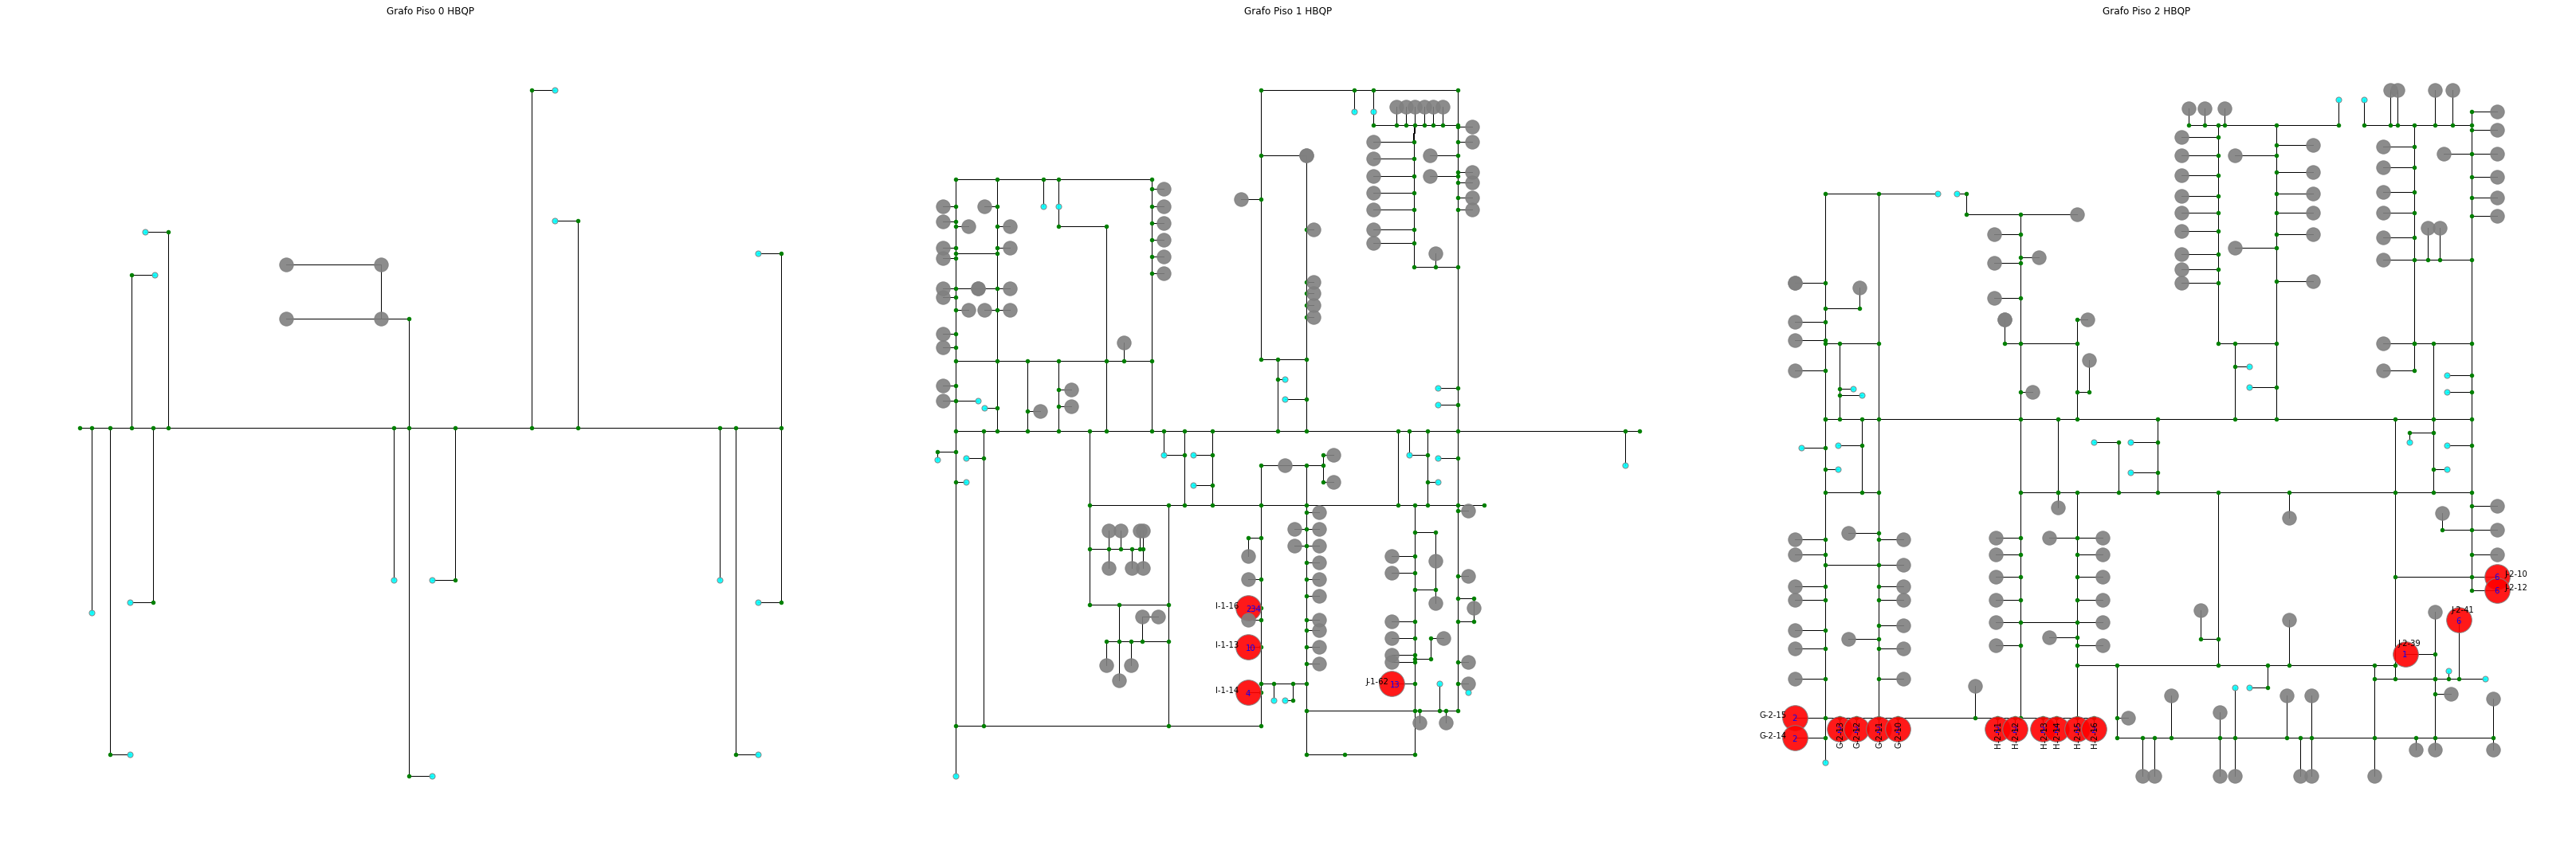

In [57]:
################################################################################
# cual es el piso que deseamos mostrar
pos1, df_nodes1 = posicion(df_nodos, '0')
pos2, df_nodes2 = posicion(df_nodos, '1')
pos3, df_nodes3 = posicion(df_nodos, '2')

################################################################################
# subgrafo solo para los nodos pertenecientes a cada piso selecionado
H1 = G.subgraph(list(df_nodes1.Nodos))
H2 = G.subgraph(list(df_nodes2.Nodos))
H3 = G.subgraph(list(df_nodes3.Nodos))

################################################################################
# vamos a normalizar los valores de la cantidad de equipos por sala para que ###
# los circulos no crescan tanto en el grafico. #################################
################################################################################
c_equipos_norm1, c_equipos1 = normalizacion_cantidad_equipos(H1, df_nodes1, 16)
c_equipos_norm2, c_equipos2 = normalizacion_cantidad_equipos(H2, df_nodes2, 16)
c_equipos_norm3, c_equipos3 = normalizacion_cantidad_equipos(H3, df_nodes3, 16)

################################################################################
# opciones que se repiten en todos los nodos
options = {"edgecolors": "tab:gray", "alpha": 0.9}

################################################################################
# mostramos el grafo  ##########################################################
################################################################################
fig, ax = plt.subplots(1,3,figsize=(45,15))

###############################################################################
# GRAFICO PISO 0 ###############################################################
################################################################################
ax[0].set_title('Grafo Piso 0 HBQP') 
# mostramos todos los nodos de los pasillos
nx.draw(H1,pos1, nodelist=list(df_nodes1.Nodos[df_nodes1.Pasillo==1]), node_color = "g", node_size=20, ax = ax[0])


#names = list(mcolors.TABLEAU_COLORS)
#colores = mcolors.TABLEAU_COLORS
#for idx, ll in enumerate(list_p0):
#  if ll:
#    nx.draw_networkx_edges(H1,pos1,edgelist = ll, edge_color=colores[names[idx]], width=ww[idx],ax = ax[0])

# mostramos todos los nodos de las salas
for idx, indice in enumerate(list(df_nodes1.Nodos[df_nodes1.Sala==1].index)):
    # var = c_equipos_norm1[idx]
    if list(df_nodes1.Nodos.iloc[[indice]])[0] in coincidencia_eq:
        cant_eq = df_temp[df_temp.sala==list(df_nodes1.Nodos.iloc[[indice]])[0]].cantidad
        nx.draw(H1, pos1, nodelist=list(df_nodes1.Nodos.iloc[[indice]]), node_color = "r",node_size=200+800, **options, ax = ax[0])
        ax[0].text(pos1[df_nodes1.Nodos[indice]][0]-2,pos1[df_nodes1.Nodos[indice]][1], s=str(list(cant_eq)[0]),fontsize=10, color = 'b',verticalalignment='center_baseline')
        
        px = list(df_nodos_p0[df_nodos_p0.Nodo==list(df_nodes1.Nodos.iloc[[indice]])[0]]['Cor_tex x'])[0]
        py = list(df_nodos_p0[df_nodos_p0.Nodo==list(df_nodes1.Nodos.iloc[[indice]])[0]]['Cor_tex y'])[0]
        rot = list(df_nodos_p0[df_nodos_p0.Nodo==list(df_nodes1.Nodos.iloc[[indice]])[0]]['rotacion'])[0]
        ax[0].text(px,py, s=list(df_nodes1.Nodos.iloc[[indice]])[0],fontsize=10,verticalalignment='center',rotation=rot)

    else:
        nx.draw(H1, pos1, nodelist=list(df_nodes1.Nodos.iloc[[indice]]), node_color = "gray",node_size=200+100, **options, ax = ax[0])
    # mostramos la cantidad de equipos x sala
    # ax[0].text(pos1[df_nodes1.Nodos[indice]][0]-2,pos1[df_nodes1.Nodos[indice]][1], s=str(c_equipos1[idx]),fontsize=8, color = 'b',verticalalignment='center_baseline')

# mostramos todos los nodos de los ascensores y escaleras
nx.draw(H1,pos1, nodelist=list(df_nodes1.Nodos[df_nodes1.Otro==1]), node_color = "cyan",node_size=50, **options, ax = ax[0])

################################################################################
# GRAFICO PISO 1 ###############################################################
################################################################################
ax[1].set_title('Grafo Piso 1 HBQP') 
# mostramos todos los nodos de los pasillos
nx.draw(H2,pos2, nodelist=list(df_nodes2.Nodos[df_nodes2.Pasillo==1]), node_color = "g", node_size=20, ax = ax[1])

#names = list(mcolors.TABLEAU_COLORS)
#colores = mcolors.TABLEAU_COLORS
#for idx, ll in enumerate(list_p1):
#  if ll:
#    nx.draw_networkx_edges(H2,pos2,edgelist = ll, edge_color=colores[names[idx]], width=ww[idx],ax = ax[1])

# mostramos todos los nodos de las salas
for idx, indice in enumerate(list(df_nodes2.Nodos[df_nodes2.Sala==1].index)):
    #var = c_equipos_norm2[idx]
    if list(df_nodes2.Nodos.iloc[[indice]])[0] in coincidencia_eq:
        cant_eq = df_temp[df_temp.sala==list(df_nodes2.Nodos.iloc[[indice]])[0]].cantidad
        nx.draw(H2, pos2, nodelist=list(df_nodes2.Nodos.iloc[[indice]]), node_color = "r",node_size=200+800, **options, ax = ax[1])
        ax[1].text(pos2[df_nodes2.Nodos[indice]][0]-2,pos2[df_nodes2.Nodos[indice]][1], s=str(list(cant_eq)[0]),fontsize=10, color = 'b',verticalalignment='center_baseline')

        px = list(df_nodos_p1[df_nodos_p1.Nodo==list(df_nodes2.Nodos.iloc[[indice]])[0]]['Cor_tex x'])[0]
        py = list(df_nodos_p1[df_nodos_p1.Nodo==list(df_nodes2.Nodos.iloc[[indice]])[0]]['Cor_tex y'])[0]
        rot = list(df_nodos_p1[df_nodos_p1.Nodo==list(df_nodes2.Nodos.iloc[[indice]])[0]]['rotacion'])[0]
        ax[1].text(px,py, s=list(df_nodes2.Nodos.iloc[[indice]])[0],fontsize=10,rotation=rot)
    else:
        nx.draw(H2, pos2, nodelist=list(df_nodes2.Nodos.iloc[[indice]]), node_color = "gray",node_size=200+100, **options, ax = ax[1])
    # mostramos la cantidad de equipos x sala
    # ax[1].text(pos2[df_nodes2.Nodos[indice]][0]-2,pos2[df_nodes2.Nodos[indice]][1], s=str(c_equipos2[idx]),fontsize=8, color = 'b',verticalalignment='center_baseline')
# mostramos todos los nodos de los ascensores y escaleras
nx.draw(H2,pos2, nodelist=list(df_nodes2.Nodos[df_nodes2.Otro==1]), node_color = "cyan",node_size=50, **options, ax = ax[1])

################################################################################
# GRAFICO PISO 2 ###############################################################
################################################################################
ax[2].set_title('Grafo Piso 2 HBQP') 
# mostramos todos los nodos de los pasillos
nx.draw(H3,pos3, nodelist=list(df_nodes3.Nodos[df_nodes3.Pasillo==1]), node_color = "g", node_size=20, ax = ax[2])

#names = list(mcolors.TABLEAU_COLORS)
#colores = mcolors.TABLEAU_COLORS
#for idx, ll in enumerate(list_p2):
#  if ll:
#    nx.draw_networkx_edges(H3,pos3,edgelist = ll, edge_color=colores[names[idx]], width=ww[idx],ax = ax[2])

# mostramos todos los nodos de las salas
for idx, indice in enumerate(list(df_nodes3.Nodos[df_nodes3.Sala==1].index)):
    #var = c_equipos_norm3[idx]
    if list(df_nodes3.Nodos.iloc[[indice]])[0] in coincidencia_eq:
        cant_eq = df_temp[df_temp.sala==list(df_nodes3.Nodos.iloc[[indice]])[0]].cantidad
        nx.draw(H3, pos3, nodelist=list(df_nodes3.Nodos.iloc[[indice]]), node_color = "r",node_size=200+800, **options, ax = ax[2])
        ax[2].text(pos3[df_nodes3.Nodos[indice]][0]-2,pos3[df_nodes3.Nodos[indice]][1], s=str(list(cant_eq)[0]),fontsize=10, color = 'b',verticalalignment='center_baseline')

        px = list(df_nodos_p2[df_nodos_p2.Nodo==list(df_nodes3.Nodos.iloc[[indice]])[0]]['Cor_tex x'])[0]
        py = list(df_nodos_p2[df_nodos_p2.Nodo==list(df_nodes3.Nodos.iloc[[indice]])[0]]['Cor_tex y'])[0]
        rot = list(df_nodos_p2[df_nodos_p2.Nodo==list(df_nodes3.Nodos.iloc[[indice]])[0]]['rotacion'])[0]
        ax[2].text(px,py, s=list(df_nodes3.Nodos.iloc[[indice]])[0],fontsize=10,rotation=rot)
    else:
        nx.draw(H3, pos3, nodelist=list(df_nodes3.Nodos.iloc[[indice]]), node_color = "gray",node_size=200+100, **options, ax = ax[2])
    # mostramos la cantidad de equipos x sala
    # ax[2].text(pos3[df_nodes3.Nodos[indice]][0]-2,pos3[df_nodes3.Nodos[indice]][1], s=str(c_equipos3[idx]),fontsize=8, color = 'b',verticalalignment='center_baseline')
# mostramos todos los nodos de los ascensores y escaleras
nx.draw(H3,pos3, nodelist=list(df_nodes3.Nodos[df_nodes3.Otro==1]), node_color = "cyan",node_size=50, **options, ax = ax[2])

################################################################################
plt.tight_layout()
plt.show()